# Introduction

Using SBERT, BERT, and GPT, each model was trained on both the sentence level and entire policy level using the labeled OPP-115 dataset. The models were then saved and subsequently tested on unlabeled policies from the ACL Coling dataset to assess their generalizability and performance.

In [1]:
device = 'cuda'
import torch, gc
import os
gc.collect()
torch.cuda.empty_cache()


In [ ]:
!pip install sentence-transformers
!pip install -U transformers
!pip install accelerate -U
!pip install nltk
!pip install tqdm
!pip install spacy beautifulsoup4
!pip -m spacy download en_core_web_sm


In [ ]:
!pip install openai
!pip install rich


In [ ]:
# all imports
import pandas as pd
import ast
import torch
from torch import nn
import numpy as np
import os
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
import spacy
import gensim
import nltk
import json
from tqdm import tqdm
from gensim import corpora
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from bs4 import BeautifulSoup
import string
from openai import OpenAI
from rich.console import Console
from rich.markdown import Markdown
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR, ExponentialLR, ReduceLROnPlateau
import torch.nn as nn
import torch.nn.functional as F
from transformers import pipeline
from transformers import BertTokenizer, BertModel
from transformers import BertForSequenceClassification
from transformers import GPT2ForSequenceClassification
from transformers import GPT2Tokenizer, GPT2Model
from sentence_transformers import SentenceTransformer
from transformers import Trainer, TrainingArguments
from torch.utils.data import DataLoader, Dataset, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from tensorboard.backend.event_processing import event_accumulator
from IPython.core.display import display, HTML
import webbrowser


In [ ]:
%env OPENAI_API_KEY=...


In [ ]:
!unzip ./OPP-115_v1_0.zip -d ./OPP-115
!unzip /content/acl-coling-2014-corpus.zip -d /content/acl_corpus



In [ ]:
# OPP-115 Categories
opp_categories = [
    "First Party Collection/Use",
    "Third Party Sharing/Collection",
    "User Choice/Control",
    "User Access, Edit, and Deletion",
    "Data Retention",
    "Data Security",
    "Policy Change",
    "Do Not Track",
    "International and Specific Audiences",
    "Other"
]

# GDPR Article 5 Principles
gdpr_principles = [
    "lawfulness, fairness and transparency",
    "purpose limitation",
    "data minimisation",
    "accuracy",
    "storage limitation",
    "integrity and confidentiality",
    "accountability"
]

In [ ]:
# OPP-115 Categories
opp_categories = [
    "First Party Collection/Use: how and why a service provider collects user information.",
    "Third Party Sharing/Collection: how user information may be shared with or collected by third parties.",
    "User Choice/Control: choices and control options available to users.",
    "User Access, Edit, & Deletion: if and how users may access, edit, or delete their information.",
    "Data Retention: how long user information is stored.",
    "Data Security: how user information is protected.",
    "Policy Change: if and how users will be informed about changes to the privacy policy.",
    "Do Not Track: if and how Do Not Track signals for online tracking and advertising are honored.",
    "International & Specific Audiences: practices that pertain only to a specific group of users (e.g., children, Europeans, or California residents).",
    "Other: additional sub-labels for introductory or general text, contact information, and practices not covered by the other categories."
]

# GDPR Article 5 Principles
gdpr_principles = [
    "Lawfulness, Fairness and Transparency: processed lawfully, fairly and in a transparent manner",
    "Purpose Limitation: collected for specified, explicit and legitimate purposes and not further processed in a manner that is incompatible with those purposes",
    "Data Minimisation: adequate, relevant and limited to what is necessary",
    "Accuracy: accurate and, where necessary, kept up to date",
    "Storage Limitation: kept in a form which permits identification of data subjects for no longer than necessary",
    "Integrity and Confidentiality: processed in a manner that ensures security of the data",
    "Accountability: the controller shall be responsible for and be able to demonstrate compliance"
]


In [ ]:
gdpr_article_5_text = """
                      1. Personal data shall be:
                      a) processed lawfully, fairly and in a transparent manner in relation to the data subject (‘lawfulness, fairness and transparency’);
                      b) collected for specified, explicit and legitimate purposes and not further processed in a manner that is incompatible with those purposes; further processing for archiving purposes in the public interest, scientific or historical research purposes or statistical purposes shall, in accordance with Article 89(1), not be considered to be incompatible with the initial purposes (‘purpose limitation’);
                      c) adequate, relevant and limited to what is necessary in relation to the purposes for which they are processed (‘data minimisation’);
                      d) accurate and, where necessary, kept up to date; every reasonable step must be taken to ensure that personal data that are inaccurate, having regard to the purposes for which they are processed, are erased or rectified without delay (‘accuracy’);
                      e) kept in a form which permits identification of data subjects for no longer than is necessary for the purposes for which the personal data are processed; personal data may be stored for longer periods insofar as the personal data will be processed solely for archiving purposes in the public interest, scientific or historical research purposes or statistical purposes in accordance with Article 89(1) subject to implementation of the appropriate technical and organisational measures required by this Regulation in order to safeguard the rights and freedoms of the data subject (‘storage limitation’);
                      f) processed in a manner that ensures appropriate security of the personal data, including protection against unauthorised or unlawful processing and against accidental loss, destruction or damage, using appropriate technical or organisational measures (‘integrity and confidentiality’).
                      2. The controller shall be responsible for, and be able to demonstrate compliance with, paragraph 1 (‘accountability’).
                      """

In [ ]:
sbert_label_descriptions = {
    0: "Lawfulness, Fairness and Transparency",
    1: "Purpose Limitation",
    2: "Data Minimization",
    3: "Accuracy",
    4: "Storage Limitation",
    5: "Integrity and Confidentiality",
    6: "Accountability",
}


In [ ]:
label_descriptions = {
    "LABEL_0": "Lawfulness, Fairness, and Transparency",
    "LABEL_1": "Purpose Limitation",
    "LABEL_2": "Data Minimization",
    "LABEL_3": "Accuracy",
    "LABEL_4": "Storage Limitation",
    "LABEL_5": "Integrity and Confidentiality (Security)",
    "LABEL_6": "Accountability"
}



In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
nlp = spacy.load("en_core_web_sm")


In [ ]:
def display_open_ai_response(response):
  console = Console()

  md = Markdown(response)

  console.print(md)

# Single Policy

In [ ]:
single_principle_df = pd.read_csv('./sentences_gdpr_label_4.csv')
single_principle_df = single_principle_df[single_principle_df['is_included'] == True]
single_principle_df.reset_index(drop=True, inplace=True)
single_principle_df['sentence_label'] = single_principle_df['sentence_label'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
single_principle_df.head()


policy_name  sentence_id  \
0  898_uptodate.com            0   
1  898_uptodate.com            1   
2  898_uptodate.com            2   
3  898_uptodate.com            3   
4  898_uptodate.com            4   

                                       sentence_text  sentence_label  \
0       UpToDate online privacy policy UpToDate Inc.               0   
1   is very sensitive to the privacy needs of its...               0   
2   UpToDate does not sell or otherwise share sub...               0   
3   To better understand UpToDate s online privac...               0   
4   Subscriber Information UpToDate never automat...               0   

   sentence_length  is_included  
0                6         True  
1               25         True  
2               16         True  
3               15         True  
4               22         True

## OPP-115 Dataset

In [ ]:
count_label_1 = single_principle_df['sentence_label'].sum()

print(f"Percentage of sentences that adhere to the specific GDPR principle: {count_label_1/len(single_principle_df)*100:.2f}")


Percentage of sentences that adhere to the specific GDPR principle: 3.20


In [ ]:
from imblearn.over_sampling import RandomOverSampler

texts = single_principle_df['sentence_text'].values
labels = single_principle_df['sentence_label'].values.reshape(-1, 1)
ros = RandomOverSampler(random_state=42)

texts_resampled, labels_resampled = ros.fit_resample(texts.reshape(-1, 1), labels)

single_principle_df_resampled = pd.DataFrame({
    'sentence_text': texts_resampled.flatten(),
    'sentence_label': labels_resampled.flatten()
})
single_principle_df_resampled.head()



sentence_text  sentence_label
0       UpToDate online privacy policy UpToDate Inc.               0
1   is very sensitive to the privacy needs of its...               0
2   UpToDate does not sell or otherwise share sub...               0
3   To better understand UpToDate s online privac...               0
4   Subscriber Information UpToDate never automat...               0

In [ ]:
count_label_1 = single_principle_df_resampled['sentence_label'].sum()

print(f"Percentage of sentences that adhere to the specific GDPR principle: {count_label_1/len(single_principle_df_resampled)*100:.2f}")


Percentage of sentences that adhere to the specific GDPR principle: 50.00


### SBERT

In [28]:
# load SBERT model
sentence_sbert_single_principle_model = SentenceTransformer('all-MiniLM-L6-v2')

def sentence_sbert_single_principle_generate_embeddings(texts):
    embeddings = sentence_sbert_single_principle_model.encode(texts, convert_to_tensor=True)
    return embeddings

def sentence_sbert_single_principle_calculate_metrics(preds, labels, threshold):
    preds = preds > threshold
    accuracy = accuracy_score(labels, preds)
    precision = precision_score(labels, preds, average='binary', zero_division=0)
    recall = recall_score(labels, preds, average='binary', zero_division=0)
    f1 = f1_score(labels, preds, average='binary', zero_division=0)
    return accuracy, precision, recall, f1


class SBERTSinglePrincipleEmbeddingDataset(Dataset):
    def __init__(self, texts, labels):
        self.embeddings = sentence_sbert_single_principle_generate_embeddings(texts)
        self.labels = torch.tensor(labels, dtype=torch.float).unsqueeze(1)

    def __len__(self):
        return len(self.embeddings)

    def __getitem__(self, idx):
        return {
            'embeddings': self.embeddings[idx],
            'labels': self.labels[idx]
        }


def train(model, train_loader, val_loader, optimizer, criterion, scheduler, epochs, device, threshold):
    history = {
        'train_loss': [], 'val_loss': [],
        'train_accuracy': [], 'val_accuracy': [],
        'train_precision': [], 'val_precision': [],
        'train_recall': [], 'val_recall': [],
        'train_f1': [], 'val_f1': []
    }

    for epoch in tqdm(range(epochs), desc="Training..."):
        # training phase
        model.train()
        train_preds, train_labels = [], []
        total_loss = 0
        for batch in train_loader:
            embeddings = batch['embeddings'].to(device)
            labels = batch['labels'].to(device)
            optimizer.zero_grad()
            outputs = model(embeddings)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            train_preds.append(torch.sigmoid(outputs).detach().cpu().numpy())
            train_labels.append(labels.cpu().numpy())

        train_preds = np.vstack(train_preds) > threshold
        train_labels = np.vstack(train_labels)
        train_acc = accuracy_score(train_labels, train_preds)
        train_prec = precision_score(train_labels, train_preds, average='binary', zero_division=0)
        train_rec = recall_score(train_labels, train_preds, average='binary', zero_division=0)
        train_f1 = f1_score(train_labels, train_preds, average='binary', zero_division=0)

        # validation phase
        model.eval()
        val_preds, val_labels = [], []
        total_val_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                embeddings = batch['embeddings'].to(device)
                labels = batch['labels'].to(device)
                outputs = model(embeddings)
                loss = criterion(outputs, labels)
                total_val_loss += loss.item()
                val_preds.append(torch.sigmoid(outputs).detach().cpu().numpy())
                val_labels.append(labels.cpu().numpy())

        val_preds = np.vstack(val_preds) > threshold
        val_labels = np.vstack(val_labels)
        val_acc = accuracy_score(val_labels, val_preds)
        val_prec = precision_score(val_labels, val_preds, average='binary', zero_division=0)
        val_rec = recall_score(val_labels, val_preds, average='binary', zero_division=0)
        val_f1 = f1_score(val_labels, val_preds, average='binary', zero_division=0)

        history['train_loss'].append(total_loss / len(train_loader))
        history['val_loss'].append(total_val_loss / len(val_loader))
        history['train_accuracy'].append(train_acc)
        history['val_accuracy'].append(val_acc)
        history['train_precision'].append(train_prec)
        history['val_precision'].append(val_prec)
        history['train_recall'].append(train_rec)
        history['val_recall'].append(val_rec)
        history['train_f1'].append(train_f1)
        history['val_f1'].append(val_f1)

    return model, history


class_counts = [np.sum(single_principle_df_resampled['sentence_label'] == 0), np.sum(single_principle_df_resampled['sentence_label'] == 1)]
total_samples = len(single_principle_df_resampled['sentence_label'])

class_weights = [total_samples / class_counts[0], total_samples / class_counts[1]]

weights_tensor = torch.tensor([class_weights[1]], dtype=torch.float, device=device)
sentence_sbert_single_principle_criterion = nn.BCEWithLogitsLoss(pos_weight=weights_tensor)

sentence_sbert_single_principle_dataset = SBERTSinglePrincipleEmbeddingDataset(single_principle_df_resampled['sentence_text'].tolist(), single_principle_df_resampled['sentence_label'].tolist())
sentence_sbert_single_principle_train_dataset, sentence_sbert_single_principle_eval_dataset = train_test_split(sentence_sbert_single_principle_dataset, test_size=0.2)

class SBertSinglePrincipleClassifier(nn.Module):
    def __init__(self, embedding_dim, hidden_dim=256):
        super(SBertSinglePrincipleClassifier, self).__init__()
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.attention = nn.Linear(2 * hidden_dim, 1)
        self.fc = nn.Linear(2 * hidden_dim, 1)

    def attention_net(self, lstm_output):
        """ Attention mechanism to weigh the importance of LSTM outputs """
        attention_scores = torch.tanh(self.attention(lstm_output))
        return torch.softmax(attention_scores, dim=1)

    def forward(self, embeddings):
        lstm_out, (hidden, _) = self.lstm(embeddings.unsqueeze(1))
        attention_weights = self.attention_net(lstm_out)
        context_vector = torch.sum(attention_weights * lstm_out, dim=1)
        out = self.fc(context_vector)
        return out

embedding_dim = sentence_sbert_single_principle_model.get_sentence_embedding_dimension()
sentence_sbert_single_principle_classifier_model = SBertSinglePrincipleClassifier(embedding_dim).to(device)

sentence_sbert_single_principle_train_loader = DataLoader(sentence_sbert_single_principle_train_dataset, batch_size=16, shuffle=True)
sentence_sbert_single_principle_val_loader = DataLoader(sentence_sbert_single_principle_eval_dataset, batch_size=16, shuffle=False)

# # train the model
# trained_model, sbert_process_history = train(sentence_sbert_single_principle_classifier_model, sentence_sbert_train_loader,
#                       sentence_sbert_val_loader, sentence_sbert_optimizer,
#                       sentence_sbert_criterion, epochs=25, device=device)

# experiment with different learning rates
learning_rates = [5e-5, 2e-5, 1e-5, 1e-4]

# experiment with different epochs
epoch_counts = [5, 10, 15, 20]

# experiment with different thresholds
thresholds = [0.3, 0.5, 0.7, 0.8]

# # experiment with different schedulers
# scheduler_1 = StepLR(optimizer, step_size=10, gamma=0.1)
# scheduler_2 = ExponentialLR(optimizer, gamma=0.95)
# scheduler_3 = ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.3)

schedulers = []

best_f1 = 0
best_model = None

for lr in tqdm(learning_rates):
    for epochs in epoch_counts:
        for threshold in thresholds:
            print(f"Training with learning rate: {lr}, epochs: {epochs}, threshold: {threshold}")
            sentence_sbert_single_principle_classifier_model = SBertSinglePrincipleClassifier(embedding_dim).to(device)
            sentence_sbert_single_principle_optimizer = Adam(sentence_sbert_single_principle_classifier_model.parameters(), lr=lr)
            sentence_sbert_single_principle_scheduler =  StepLR(sentence_sbert_single_principle_optimizer, step_size=10, gamma=0.15)
            trained_model, sbert_process_history = train(sentence_sbert_single_principle_classifier_model, sentence_sbert_single_principle_train_loader,
                                sentence_sbert_single_principle_val_loader, sentence_sbert_single_principle_optimizer,
                                sentence_sbert_single_principle_criterion, scheduler=sentence_sbert_single_principle_scheduler,
                                                         epochs=epochs, device=device, threshold=threshold)
            current_f1 = sbert_process_history['val_f1'][-1]
            if current_f1 > best_f1:
                best_threshold = threshold
                best_lr = lr
                best_epochs = epochs
                best_history = sbert_process_history
                best_f1 = current_f1
                best_model = trained_model

print(f"Best model F1 score: {best_f1}")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
  0%|          | 0/4 [00:00<?, ?it/s]

Training with learning rate: 5e-05, epochs: 5, threshold: 0.3



Training...: 100%|██████████| 5/5 [00:16<00:00,  3.36s/it]


Training with learning rate: 5e-05, epochs: 5, threshold: 0.5



Training...: 100%|██████████| 5/5 [00:16<00:00,  3.39s/it]


Training with learning rate: 5e-05, epochs: 5, threshold: 0.7



Training...: 100%|██████████| 5/5 [00:16<00:00,  3.37s/it]


Training with learning rate: 5e-05, epochs: 5, threshold: 0.8



Training...: 100%|██████████| 5/5 [00:16<00:00,  3.38s/it]


Training with learning rate: 5e-05, epochs: 10, threshold: 0.3



Training...: 100%|██████████| 10/10 [00:33<00:00,  3.39s/it]


Training with learning rate: 5e-05, epochs: 10, threshold: 0.5



Training...: 100%|██████████| 10/10 [00:33<00:00,  3.38s/it]


Training with learning rate: 5e-05, epochs: 10, threshold: 0.7



Training...: 100%|██████████| 10/10 [00:33<00:00,  3.37s/it]


Training with learning rate: 5e-05, epochs: 10, threshold: 0.8



Training...: 100%|██████████| 10/10 [00:33<00:00,  3.37s/it]


Training with learning rate: 5e-05, epochs: 15, threshold: 0.3



Training...: 100%|██████████| 15/15 [00:50<00:00,  3.37s/it]


Training with learning rate: 5e-05, epochs: 15, threshold: 0.5



Training...: 100%|██████████| 15/15 [00:50<00:00,  3.37s/it]


Training with learning rate: 5e-05, epochs: 15, threshold: 0.7



Training...: 100%|██████████| 15/15 [00:50<00:00,  3.39s/it]


Training with learning rate: 5e-05, epochs: 15, threshold: 0.8



Training...: 100%|██████████| 15/15 [00:50<00:00,  3.37s/it]


Training with learning rate: 5e-05, epochs: 20, threshold: 0.3



Training...: 100%|██████████| 20/20 [01:08<00:00,  3.41s/it]


Training with learning rate: 5e-05, epochs: 20, threshold: 0.5



Training...: 100%|██████████| 20/20 [01:07<00:00,  3.39s/it]


Training with learning rate: 5e-05, epochs: 20, threshold: 0.7



Training...: 100%|██████████| 20/20 [01:07<00:00,  3.38s/it]


Training with learning rate: 5e-05, epochs: 20, threshold: 0.8



 25%|██▌       | 1/4 [11:16<33:49, 676.46s/it]

Training with learning rate: 2e-05, epochs: 5, threshold: 0.3



Training...: 100%|██████████| 5/5 [00:16<00:00,  3.39s/it]


Training with learning rate: 2e-05, epochs: 5, threshold: 0.5



Training...: 100%|██████████| 5/5 [00:16<00:00,  3.37s/it]


Training with learning rate: 2e-05, epochs: 5, threshold: 0.7



Training...: 100%|██████████| 5/5 [00:16<00:00,  3.37s/it]


Training with learning rate: 2e-05, epochs: 5, threshold: 0.8



Training...: 100%|██████████| 5/5 [00:16<00:00,  3.39s/it]


Training with learning rate: 2e-05, epochs: 10, threshold: 0.3



Training...: 100%|██████████| 10/10 [00:33<00:00,  3.39s/it]


Training with learning rate: 2e-05, epochs: 10, threshold: 0.5



Training...: 100%|██████████| 10/10 [00:33<00:00,  3.37s/it]


Training with learning rate: 2e-05, epochs: 10, threshold: 0.7



Training...: 100%|██████████| 10/10 [00:33<00:00,  3.37s/it]


Training with learning rate: 2e-05, epochs: 10, threshold: 0.8



Training...: 100%|██████████| 10/10 [00:33<00:00,  3.38s/it]


Training with learning rate: 2e-05, epochs: 15, threshold: 0.3



Training...: 100%|██████████| 15/15 [00:50<00:00,  3.37s/it]


Training with learning rate: 2e-05, epochs: 15, threshold: 0.5



Training...: 100%|██████████| 15/15 [00:50<00:00,  3.38s/it]


Training with learning rate: 2e-05, epochs: 15, threshold: 0.7



Training...: 100%|██████████| 15/15 [00:50<00:00,  3.38s/it]


Training with learning rate: 2e-05, epochs: 15, threshold: 0.8



Training...: 100%|██████████| 15/15 [00:50<00:00,  3.38s/it]


Training with learning rate: 2e-05, epochs: 20, threshold: 0.3



Training...: 100%|██████████| 20/20 [01:07<00:00,  3.37s/it]


Training with learning rate: 2e-05, epochs: 20, threshold: 0.5



Training...: 100%|██████████| 20/20 [01:07<00:00,  3.37s/it]


Training with learning rate: 2e-05, epochs: 20, threshold: 0.7



Training...: 100%|██████████| 20/20 [01:07<00:00,  3.39s/it]


Training with learning rate: 2e-05, epochs: 20, threshold: 0.8



 50%|█████     | 2/4 [22:32<22:32, 676.13s/it]

Training with learning rate: 1e-05, epochs: 5, threshold: 0.3



Training...: 100%|██████████| 5/5 [00:16<00:00,  3.38s/it]


Training with learning rate: 1e-05, epochs: 5, threshold: 0.5



Training...: 100%|██████████| 5/5 [00:16<00:00,  3.38s/it]


Training with learning rate: 1e-05, epochs: 5, threshold: 0.7



Training...: 100%|██████████| 5/5 [00:16<00:00,  3.36s/it]


Training with learning rate: 1e-05, epochs: 5, threshold: 0.8



Training...: 100%|██████████| 5/5 [00:16<00:00,  3.40s/it]


Training with learning rate: 1e-05, epochs: 10, threshold: 0.3



Training...: 100%|██████████| 10/10 [00:33<00:00,  3.38s/it]


Training with learning rate: 1e-05, epochs: 10, threshold: 0.5



Training...: 100%|██████████| 10/10 [00:33<00:00,  3.37s/it]


Training with learning rate: 1e-05, epochs: 10, threshold: 0.7



Training...: 100%|██████████| 10/10 [00:33<00:00,  3.37s/it]


Training with learning rate: 1e-05, epochs: 10, threshold: 0.8



Training...: 100%|██████████| 10/10 [00:33<00:00,  3.37s/it]


Training with learning rate: 1e-05, epochs: 15, threshold: 0.3



Training...: 100%|██████████| 15/15 [00:50<00:00,  3.39s/it]


Training with learning rate: 1e-05, epochs: 15, threshold: 0.5



Training...: 100%|██████████| 15/15 [00:50<00:00,  3.38s/it]


Training with learning rate: 1e-05, epochs: 15, threshold: 0.7



Training...: 100%|██████████| 15/15 [00:50<00:00,  3.37s/it]


Training with learning rate: 1e-05, epochs: 15, threshold: 0.8



Training...: 100%|██████████| 15/15 [00:50<00:00,  3.38s/it]


Training with learning rate: 1e-05, epochs: 20, threshold: 0.3



Training...: 100%|██████████| 20/20 [01:07<00:00,  3.38s/it]


Training with learning rate: 1e-05, epochs: 20, threshold: 0.5



Training...: 100%|██████████| 20/20 [01:08<00:00,  3.40s/it]


Training with learning rate: 1e-05, epochs: 20, threshold: 0.7



Training...: 100%|██████████| 20/20 [01:07<00:00,  3.39s/it]


Training with learning rate: 1e-05, epochs: 20, threshold: 0.8



 75%|███████▌  | 3/4 [33:49<11:16, 676.39s/it]

Training with learning rate: 0.0001, epochs: 5, threshold: 0.3



Training...: 100%|██████████| 5/5 [00:16<00:00,  3.37s/it]


Training with learning rate: 0.0001, epochs: 5, threshold: 0.5



Training...: 100%|██████████| 5/5 [00:16<00:00,  3.36s/it]


Training with learning rate: 0.0001, epochs: 5, threshold: 0.7



Training...: 100%|██████████| 5/5 [00:16<00:00,  3.38s/it]


Training with learning rate: 0.0001, epochs: 5, threshold: 0.8



Training...: 100%|██████████| 5/5 [00:16<00:00,  3.39s/it]


Training with learning rate: 0.0001, epochs: 10, threshold: 0.3



Training...: 100%|██████████| 10/10 [00:33<00:00,  3.38s/it]


Training with learning rate: 0.0001, epochs: 10, threshold: 0.5



Training...: 100%|██████████| 10/10 [00:33<00:00,  3.36s/it]


Training with learning rate: 0.0001, epochs: 10, threshold: 0.7



Training...: 100%|██████████| 10/10 [00:34<00:00,  3.44s/it]


Training with learning rate: 0.0001, epochs: 10, threshold: 0.8



Training...: 100%|██████████| 10/10 [00:34<00:00,  3.44s/it]


Training with learning rate: 0.0001, epochs: 15, threshold: 0.3



Training...: 100%|██████████| 15/15 [00:50<00:00,  3.39s/it]


Training with learning rate: 0.0001, epochs: 15, threshold: 0.5



Training...: 100%|██████████| 15/15 [00:51<00:00,  3.41s/it]


Training with learning rate: 0.0001, epochs: 15, threshold: 0.7



Training...: 100%|██████████| 15/15 [00:50<00:00,  3.39s/it]


Training with learning rate: 0.0001, epochs: 15, threshold: 0.8



Training...: 100%|██████████| 15/15 [00:51<00:00,  3.43s/it]


Training with learning rate: 0.0001, epochs: 20, threshold: 0.3



Training...: 100%|██████████| 20/20 [01:07<00:00,  3.38s/it]


Training with learning rate: 0.0001, epochs: 20, threshold: 0.5



Training...: 100%|██████████| 20/20 [01:07<00:00,  3.37s/it]


Training with learning rate: 0.0001, epochs: 20, threshold: 0.7



Training...: 100%|██████████| 20/20 [01:07<00:00,  3.37s/it]


Training with learning rate: 0.0001, epochs: 20, threshold: 0.8



100%|██████████| 4/4 [45:07<00:00, 676.78s/it]

Best model F1 score: 0.910171102661597


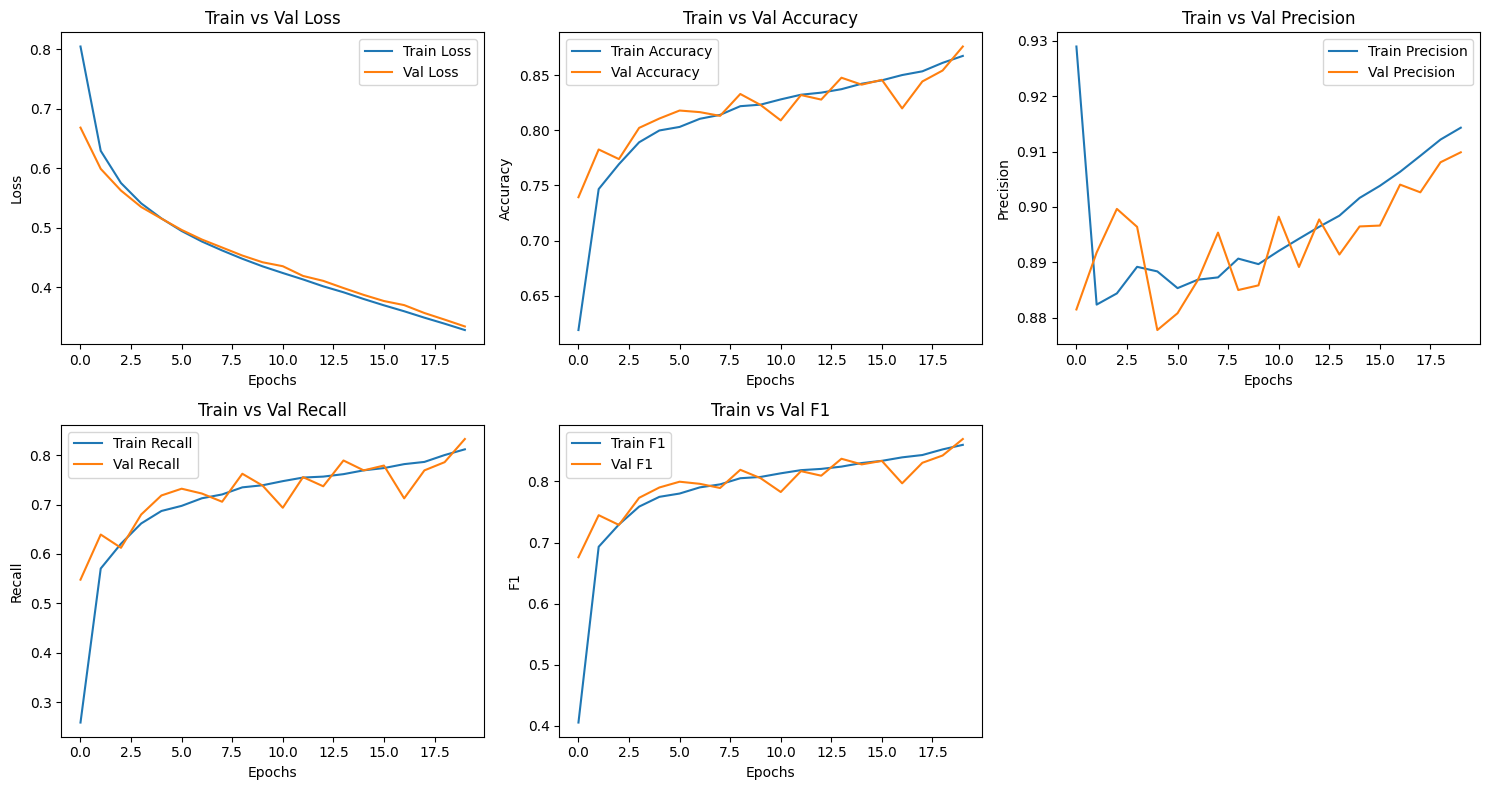

In [32]:
def plot_training_history(history):
    metrics = ['loss', 'accuracy', 'precision', 'recall', 'f1']
    plt.figure(figsize=(15, 8))

    for i, metric in enumerate(metrics):
        plt.subplot(2, 3, i+1)
        plt.plot(history[f'train_{metric}'], label=f'Train {metric.capitalize()}')
        plt.plot(history[f'val_{metric}'], label=f'Val {metric.capitalize()}')
        plt.title(f'Train vs Val {metric.capitalize()}')
        plt.xlabel('Epochs')
        plt.ylabel(metric.capitalize())
        plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(sbert_process_history)


In [33]:
def save_model(model, path):
    torch.save(model.state_dict(), path)

# save the trained model
save_model(best_model, './sentence_sbert_model_single_policy_path.pth')


In [34]:
def predict(text):
    with torch.no_grad():
        embeddings = sentence_sbert_single_principle_model.encode([text], convert_to_tensor=True).to(device)
        outputs = sentence_sbert_single_principle_classifier_model(embeddings)
        preds = torch.sigmoid(outputs).cpu().numpy() > 0.8
    return preds

sample_sentence_1 = "we collect two kinds of information related to you: (a) personally identifiable information (“pii”); and (b) non-personally identifiable information (“non-pii”)."
sample_sentence_2 = "furthermore, some information is never completely removed from our databases due to technical (e.g., information that is stored in our “back-up” systems) and certain legal constraints."
sample_sentence_3 = "this policy states that user data will be stored for a maximum of two years."
sample_sentence_4 = "we reveal only the last four digits of your credit card numbers when confirming an order."

sentence_1_sbert_prediction = predict(sample_sentence_1)
print("Prediction 1:", sentence_1_sbert_prediction)

sentence_2_sbert_prediction = predict(sample_sentence_2)
print("Prediction 2:", sentence_2_sbert_prediction)

sentence_3_sbert_prediction = predict(sample_sentence_3)
print("Prediction 3:", sentence_3_sbert_prediction)

sentence_4_sbert_prediction = predict(sample_sentence_4)
print("Prediction 4:", sentence_4_sbert_prediction)


Prediction 1: [[False]]
Prediction 2: [[ True]]
Prediction 3: [[ True]]
Prediction 4: [[False]]


In [ ]:
nltk.download('punkt')

def predict_and_filter_sentences(policy_text, model, threshold=0.8):
    sentences = sent_tokenize(policy_text)
    adhering_sentences = []

    with torch.no_grad():
        embeddings = sentence_sbert_single_principle_model.encode(sentences, convert_to_tensor=True).to(device)
        outputs = sentence_sbert_single_principle_classifier_model(embeddings)
        probs = torch.sigmoid(outputs).cpu().numpy()

        for sentence, prob in zip(sentences, probs):
            if prob > threshold:
                adhering_sentences.append(sentence)

    return adhering_sentences

policy_text = """Privacy Policy

Last Updated: June 10, 2024

Introduction

Welcome to [Company Name] ("we", "us", "our"). We are committed to protecting and respecting your privacy. This policy explains how we collect, use, and disclose your personal data, as well as your rights in relation to that data.

1. Information We Collect

We collect various types of information in connection with the services we provide, including:
- Personal Identification Information: such as name, email address, phone number, etc.
- Demographic Information: such as age, gender, interests, etc.
- Behavioral Information: regarding how you use our services.

2. Use of Information

We use the collected information for various purposes, including:
- Providing and maintaining our services.
- Personalizing user experience.
- Improving our services based on user feedback.
- Communicating with you regarding updates, promotions, and other information.

3. Storing and Retention

a. Retention Period

We will retain your personal data only for as long as is necessary for the purposes set out in this privacy policy. The criteria we use to determine retention periods include:
- The length of time we have an ongoing relationship with you and provide services to you.
- Whether there is a legal obligation to which we are subject (e.g., certain laws require us to keep records of your transactions for a certain period before we can delete them).
- Whether retention is advisable considering our legal position (such as in regard to applicable statutes of limitations, litigation, or regulatory investigations).

b. Secure Deletion

Once the retention period expires, we will securely delete your personal data. Methods of deletion may include:
- Permanently deleting electronic records.
- Securely shredding physical documents.
- Anonymizing the data so that it can no longer be associated with you.

4. Data Security

We implement appropriate technical and organizational measures to protect your personal data against unauthorized access, alteration, disclosure, or destruction. These measures include encryption, access controls, and secure data storage facilities.

5. Your Data Protection Rights

Depending on your location and applicable data protection laws, you may have the following rights:
- The right to access your personal data.
- The right to rectify incorrect or incomplete data.
- The right to erasure (the "right to be forgotten").
- The right to restrict the processing of your data.
- The right to data portability.
- The right to object to the processing of your data.

6. Changes to This Privacy Policy

We may update our privacy policy from time to time. We will notify you of any changes by posting the new privacy policy on this page. You are advised to review this policy periodically for any changes.

Contact Us

If you have any questions or concerns about this privacy policy, please contact us at:

[Company Name]
[Address]
[Email]
[Phone Number]
"""

adhering_sentences = predict_and_filter_sentences(policy_text, sentence_sbert_single_principle_classifier_model, threshold=0.8)
print("Adhering Sentences:")
for sentence in adhering_sentences:
    print(sentence)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Adhering Sentences:
Information We Collect

We collect various types of information in connection with the services we provide, including:
- Personal Identification Information: such as name, email address, phone number, etc.
Use of Information

We use the collected information for various purposes, including:
- Providing and maintaining our services.
Storing and Retention

a.
Retention Period

We will retain your personal data only for as long as is necessary for the purposes set out in this privacy policy.
The criteria we use to determine retention periods include:
- The length of time we have an ongoing relationship with you and provide services to you.
- Whether there is a legal obligation to which we are subject (e.g., certain laws require us to keep records of your transactions for a certain period before we can delete them).
- Whether retention is advisable considering our legal position (such as in regard to applicable statutes of limitations, litigation, or regulatory investig

### BERT

In [ ]:
class PrivacyPolicySinglePrincipleSentenceDataset(Dataset):
    def __init__(self, texts, label, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.texts = texts
        self.label = label
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        text = str(self.texts[item])
        label = self.label[item]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.float)
        }


In [ ]:
sentence_bert_single_principle_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
max_len = 512

sentences_single_principle_dataset = PrivacyPolicySinglePrincipleSentenceDataset(single_principle_df_resampled['sentence_text'], single_principle_df_resampled['sentence_label'], sentence_bert_single_principle_tokenizer, max_len)

sentence_bert_single_principle_train_dataset, sentence_bert_single_principle_eval_dataset = train_test_split(sentences_single_principle_dataset, test_size=0.2)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sentence_bert_single_principle_compute_metrics(eval_pred):
    logits, labels = eval_pred
    probs = sigmoid(logits.squeeze(-1))
    preds = (probs > 0.8).astype(int)

    accuracy = accuracy_score(labels, preds)
    precision = precision_score(labels, preds, average='binary', zero_division=0)
    recall = recall_score(labels, preds, average='binary', zero_division=0)
    f1 = f1_score(labels, preds, average='binary', zero_division=0)

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

sentence_bert_single_principle_model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=1)

labels = torch.tensor(single_principle_df_resampled['sentence_label'].values)

number_positives = torch.sum(labels == 1)
number_negatives = torch.sum(labels == 0)

pos_weight = number_negatives.float() / number_positives.float()

sentence_bert_single_principle_criterion = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight)

class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.get('logits')
        loss_fct = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight)
        loss = loss_fct(logits.view(-1), labels.float().view(-1))
        return (loss, outputs) if return_outputs else loss

# training arguments
sentence_bert_single_principle_training_args = TrainingArguments(
    learning_rate=1e-4,
    output_dir='./sentence_bert_single_principle_results',
    num_train_epochs=5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./sentence_bert_single_principle_logs',
    eval_steps=50,
    logging_steps=50,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True
)

# initialize the trainer
sentence_bert_single_principle_trainer = WeightedTrainer(
    model=sentence_bert_single_principle_model,
    args=sentence_bert_single_principle_training_args,
    train_dataset=sentence_bert_single_principle_train_dataset,
    eval_dataset=sentence_bert_single_principle_eval_dataset,
    compute_metrics=sentence_bert_single_principle_compute_metrics
)

sentence_bert_single_principle_trainer.train()


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


TrainOutput(global_step=10330, training_loss=0.091550362165855, metrics={'train_runtime': 8271.2115, 'train_samples_per_second': 9.991, 'train_steps_per_second': 1.249, 'total_flos': 2.174330238885888e+16, 'train_loss': 0.091550362165855, 'epoch': 5.0})

In [ ]:
sentence_bert_single_principle_trainer.evaluate()


{'eval_loss': 0.027219785377383232,
 'eval_accuracy': 0.9954017424975798,
 'eval_precision': 0.991016548463357,
 'eval_recall': 1.0,
 'eval_f1': 0.995488007599145,
 'eval_runtime': 122.2798,
 'eval_samples_per_second': 33.791,
 'eval_steps_per_second': 2.118,
 'epoch': 5.0}

In [ ]:
# save the trained model
sentence_bert_single_principle_model_path = "./sentence_bert_single_principle_model"
sentence_bert_single_principle_model.save_pretrained(sentence_bert_single_principle_model_path)
sentence_bert_single_principle_tokenizer.save_pretrained(sentence_bert_single_principle_model_path)


('./sentence_bert_single_principle_model/tokenizer_config.json',
 './sentence_bert_single_principle_model/special_tokens_map.json',
 './sentence_bert_single_principle_model/vocab.txt',
 './sentence_bert_single_principle_model/added_tokens.json')

In [ ]:
!zip -r sentence_bert_single_principle_logs.zip sentence_bert_single_principle_logs/
!zip -r sentence_bert_single_principle_results.zip sentence_bert_single_principle_results/
!zip -r sentence_bert_single_principle_model.zip sentence_bert_single_principle_model/


  adding: sentence_bert_single_principle_logs/ (stored 0%)
  adding: sentence_bert_single_principle_logs/events.out.tfevents.1718614556.5a2055ebb5be.235.0 (deflated 68%)
  adding: sentence_bert_single_principle_logs/events.out.tfevents.1718623100.5a2055ebb5be.235.1 (deflated 29%)
  adding: sentence_bert_single_principle_results/ (stored 0%)
  adding: sentence_bert_single_principle_results/checkpoint-6198/ (stored 0%)
  adding: sentence_bert_single_principle_results/checkpoint-6198/rng_state.pth (deflated 25%)
  adding: sentence_bert_single_principle_results/checkpoint-6198/scheduler.pt (deflated 55%)
  adding: sentence_bert_single_principle_results/checkpoint-6198/trainer_state.json (deflated 77%)
  adding: sentence_bert_single_principle_results/checkpoint-6198/training_args.bin (deflated 51%)
  adding: sentence_bert_single_principle_results/checkpoint-6198/optimizer.pt (deflated 25%)
  adding: sentence_bert_single_principle_results/checkpoint-6198/model.safetensors (deflated 7%)
  add

['train/loss', 'train/grad_norm', 'train/learning_rate', 'train/epoch', 'eval/loss', 'eval/accuracy', 'eval/precision', 'eval/recall', 'eval/f1', 'eval/runtime', 'eval/samples_per_second', 'eval/steps_per_second', 'train/train_runtime', 'train/train_samples_per_second', 'train/train_steps_per_second', 'train/total_flos', 'train/train_loss']


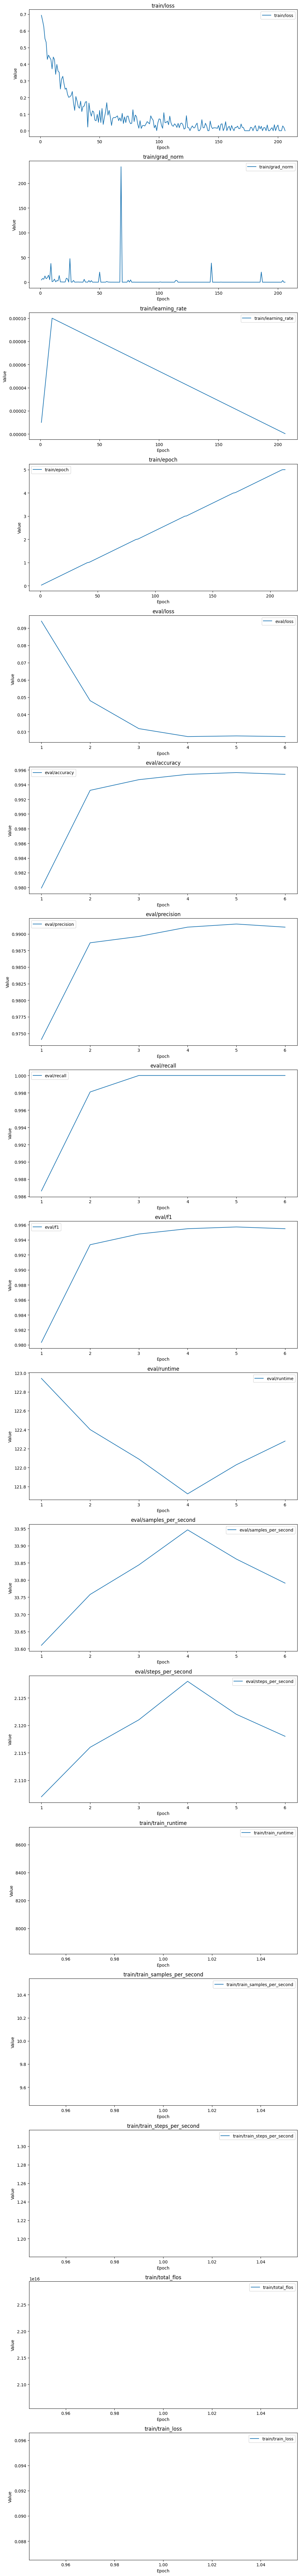

In [ ]:
sentence_bert_logdir = './sentence_bert_single_principle_logs'

# load the data
ea = event_accumulator.EventAccumulator(sentence_bert_logdir)
ea.Reload()

print(ea.Tags()['scalars'])

def extract_metric(metric_name):
    if metric_name in ea.scalars.Keys():
        return [x.value for x in ea.scalars.Items(metric_name)]
    else:
        return []

metrics_dict = {key: extract_metric(key) for key in ['train/loss',
                                                     'train/grad_norm',
                                                     'train/learning_rate',
                                                     'train/epoch',
                                                     'eval/loss',
                                                     'eval/accuracy',
                                                     'eval/precision',
                                                     'eval/recall', 'eval/f1',
                                                     'eval/runtime',
                                                     'eval/samples_per_second',
                                                     'eval/steps_per_second',
                                                     'train/train_runtime',
                                                     'train/train_samples_per_second',
                                                     'train/train_steps_per_second',
                                                     'train/total_flos', 'train/train_loss']
}

num_plots = len(metrics_dict)

fig, axs = plt.subplots(num_plots, 1, figsize=(10, 5 * num_plots))
axs = axs.flatten()

# plot each metric
for i, (metric, values) in enumerate(metrics_dict.items()):
    epochs = range(1, len(values)+1)
    axs[i].plot(epochs, values, label=metric)
    axs[i].set_title(metric)
    axs[i].set_xlabel('Epoch')
    axs[i].set_ylabel('Value')
    axs[i].legend()

plt.tight_layout()
plt.show()


In [ ]:
def predict_compliance(sentence, model, tokenizer, device, threshold=0.8):
    model.to(device)
    model.eval()

    encoding = tokenizer.encode_plus(
        sentence,
        add_special_tokens=True,
        max_length=512,
        return_token_type_ids=False,
        padding='max_length',
        return_attention_mask=True,
        return_tensors='pt',
        truncation=True
    )

    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs[0]

    probs = torch.sigmoid(logits).cpu().numpy()
    prediction = (probs > threshold).astype(int)

    return {
        'sentence': sentence,
        'probability': probs.flatten(),
        'compliance': prediction.flatten(),
        'is_compliant': "Compliant" if prediction else "Not Compliant"
    }

result_1 = predict_compliance(sample_sentence_1, sentence_bert_single_principle_model, sentence_bert_single_principle_tokenizer, device)
print(f"Prediction 1: {result_1}")

result_2 = predict_compliance(sample_sentence_2, sentence_bert_single_principle_model, sentence_bert_single_principle_tokenizer, device)
print(f"Prediction 2: {result_2}")

result_3 = predict_compliance(sample_sentence_3, sentence_bert_single_principle_model, sentence_bert_single_principle_tokenizer, device)
print(f"Prediction 3: {result_3}")

result_4 = predict_compliance(sample_sentence_4, sentence_bert_single_principle_model, sentence_bert_single_principle_tokenizer, device)
print(f"Prediction 4: {result_4}")


Prediction 1: {'sentence': 'we collect two kinds of information related to you: (a) personally identifiable information (“pii”); and (b) non-personally identifiable information (“non-pii”).', 'probability': array([0.00010669], dtype=float32), 'compliance': array([0]), 'is_compliant': 'Not Compliant'}
Prediction 2: {'sentence': 'furthermore, some information is never completely removed from our databases due to technical (e.g., information that is stored in our “back-up” systems) and certain legal constraints.', 'probability': array([0.9992848], dtype=float32), 'compliance': array([1]), 'is_compliant': 'Compliant'}
Prediction 3: {'sentence': 'this policy states that user data will be stored for a maximum of two years.', 'probability': array([0.00010351], dtype=float32), 'compliance': array([0]), 'is_compliant': 'Not Compliant'}
Prediction 4: {'sentence': 'we reveal only the last four digits of your credit card numbers when confirming an order.', 'probability': array([0.00010369], dtype=

In [ ]:
def split_policy_into_sentences(policy):
    doc = nlp(policy)
    sentences = [sent.text for sent in doc.sents]
    return sentences

def predict_compliance(sentence, model, tokenizer, device, threshold=0.8):
    model.to(device)
    model.eval()

    encoding = tokenizer.encode_plus(
        sentence,
        add_special_tokens=True,
        max_length=512,
        return_token_type_ids=False,
        padding='max_length',
        return_attention_mask=True,
        return_tensors='pt',
        truncation=True
    )

    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs[0]

    probs = torch.sigmoid(logits).cpu().numpy()
    prediction = (probs > threshold).astype(int)

    return {
        'sentence': sentence,
        'probability': probs.flatten(),
        'compliance': prediction.flatten(),
        'is_compliant': "Compliant" if prediction else "Not Compliant"
    }

def check_policy_compliance(policy, model, tokenizer, device, threshold=0.8):
    sentences = split_policy_into_sentences(policy)
    results = []
    compliant_sentences = []

    for sentence in sentences:
        result = predict_compliance(sentence, model, tokenizer, device, threshold)
        results.append(result)
        if result['is_compliant'] == "Compliant":
            compliant_sentences.append(result)

    return results, compliant_sentences

results, compliant_sentences = check_policy_compliance(policy_text, sentence_bert_single_principle_model, sentence_bert_single_principle_tokenizer, device)

print("Compliant Sentences:")
for compliant in compliant_sentences:
    print(f"Sentence: {compliant['sentence']}")
    print(f"Probability: {compliant['probability']}")
    print()



Compliant Sentences:
Sentence: Storing and Retention

a. Retention Period

We will retain your personal data only for as long as is necessary for the purposes set out in this privacy policy.
Probability: [0.99931455]

Sentence: - Whether there is a legal obligation to which we are subject (e.g., certain laws require us to keep records of your transactions for a certain period before we can delete them).
-
Probability: [0.9992951]

Sentence: Secure Deletion

Once the retention period expires, we will securely delete your personal data.
Probability: [0.9992908]



### GPT2

In [ ]:
sentence_gpt_single_principle_tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
if sentence_gpt_single_principle_tokenizer.pad_token is None:
    sentence_gpt_single_principle_tokenizer.pad_token = sentence_gpt_single_principle_tokenizer.eos_token

max_len = 512

sentences_single_principle_dataset = PrivacyPolicySinglePrincipleSentenceDataset(single_principle_df_resampled['sentence_text'], single_principle_df_resampled['sentence_label'], sentence_gpt_single_principle_tokenizer, max_len)

sentence_gpt_single_principle_train_dataset, sentence_gpt_single_principle_eval_dataset = train_test_split(sentences_single_principle_dataset, test_size=0.2)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sentence_gpt_single_principle_compute_metrics(eval_pred):
    logits, labels = eval_pred
    probs = sigmoid(logits.squeeze(-1))
    preds = (probs > 0.8).astype(int)

    accuracy = accuracy_score(labels, preds)
    precision = precision_score(labels, preds, average='binary', zero_division=0)
    recall = recall_score(labels, preds, average='binary', zero_division=0)
    f1 = f1_score(labels, preds, average='binary', zero_division=0)

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

sentence_gpt_single_principle_model = GPT2ForSequenceClassification.from_pretrained('gpt2', pad_token_id=sentence_gpt_single_principle_tokenizer.eos_token_id, num_labels=1)
sentence_gpt_single_principle_model.resize_token_embeddings(len(sentence_gpt_single_principle_tokenizer))

labels = torch.tensor(single_principle_df_resampled['sentence_label'].values)

number_positives = torch.sum(labels == 1)
number_negatives = torch.sum(labels == 0)

pos_weight = number_negatives.float() / number_positives.float()

sentence_gpt_single_principle_criterion = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight)

class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.get('logits')
        loss_fct = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight)
        loss = loss_fct(logits.view(-1), labels.float().view(-1))
        return (loss, outputs) if return_outputs else loss

# training arguments
sentence_gpt_single_principle_training_args = TrainingArguments(
    learning_rate=1e-4,
    output_dir='./sentence_gpt_single_principle_results',
    num_train_epochs=5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./sentence_gpt_single_principle_logs',
    logging_steps=50,
    eval_steps=50,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True
)

sentence_gpt_single_principle_trainer = WeightedTrainer(
    model=sentence_gpt_single_principle_model,
    args=sentence_gpt_single_principle_training_args,
    train_dataset=sentence_gpt_single_principle_train_dataset,
    eval_dataset=sentence_gpt_single_principle_eval_dataset,
    compute_metrics=sentence_gpt_single_principle_compute_metrics
)

sentence_gpt_single_principle_trainer.train()


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


TrainOutput(global_step=10330, training_loss=0.08161169214799391, metrics={'train_runtime': 9522.2371, 'train_samples_per_second': 8.679, 'train_steps_per_second': 1.085, 'total_flos': 2.159336849670144e+16, 'train_loss': 0.08161169214799391, 'epoch': 5.0})

In [ ]:
sentence_gpt_single_principle_trainer.evaluate()


{'eval_loss': 0.039782069623470306,
 'eval_accuracy': 0.9954017424975798,
 'eval_precision': 0.9908123791102514,
 'eval_recall': 1.0,
 'eval_f1': 0.995384989069711,
 'eval_runtime': 145.7668,
 'eval_samples_per_second': 28.347,
 'eval_steps_per_second': 1.777,
 'epoch': 5.0}

In [ ]:
# save the trained model
sentence_gpt_single_principle_model_path = "./sentence_gpt_single_principle_model"
sentence_gpt_single_principle_model.save_pretrained(sentence_gpt_single_principle_model_path)
sentence_gpt_single_principle_tokenizer.save_pretrained(sentence_gpt_single_principle_model_path)


('./sentence_gpt_single_principle_model/tokenizer_config.json',
 './sentence_gpt_single_principle_model/special_tokens_map.json',
 './sentence_gpt_single_principle_model/vocab.json',
 './sentence_gpt_single_principle_model/merges.txt',
 './sentence_gpt_single_principle_model/added_tokens.json')

In [ ]:
!zip -r sentence_gpt_single_principle_logs.zip sentence_gpt_single_principle_logs/
!zip -r sentence_gpt_single_principle_results.zip sentence_gpt_single_principle_results/
!zip -r sentence_gpt_single_principle_model.zip sentence_gpt_single_principle_model/


  adding: sentence_gpt_single_principle_logs/ (stored 0%)
  adding: sentence_gpt_single_principle_logs/events.out.tfevents.1718633179.5a2055ebb5be.235.3 (deflated 29%)
  adding: sentence_gpt_single_principle_logs/events.out.tfevents.1718623511.5a2055ebb5be.235.2 (deflated 68%)
  adding: sentence_gpt_single_principle_results/ (stored 0%)
  adding: sentence_gpt_single_principle_results/checkpoint-6198/ (stored 0%)
  adding: sentence_gpt_single_principle_results/checkpoint-6198/rng_state.pth (deflated 25%)
  adding: sentence_gpt_single_principle_results/checkpoint-6198/scheduler.pt (deflated 55%)
  adding: sentence_gpt_single_principle_results/checkpoint-6198/trainer_state.json (deflated 78%)
  adding: sentence_gpt_single_principle_results/checkpoint-6198/training_args.bin (deflated 51%)
  adding: sentence_gpt_single_principle_results/checkpoint-6198/optimizer.pt (deflated 33%)
  adding: sentence_gpt_single_principle_results/checkpoint-6198/model.safetensors (deflated 7%)
  adding: senten

In [ ]:
result_1 = predict_compliance(sample_sentence_1, sentence_gpt_single_principle_model, sentence_gpt_single_principle_tokenizer, device)
print(f"Prediction 1: {result_1}")

result_2 = predict_compliance(sample_sentence_2, sentence_gpt_single_principle_model, sentence_gpt_single_principle_tokenizer, device)
print(f"Prediction 2: {result_2}")

result_3 = predict_compliance(sample_sentence_3, sentence_gpt_single_principle_model, sentence_gpt_single_principle_tokenizer, device)
print(f"Prediction 3: {result_3}")

result_4 = predict_compliance(sample_sentence_4, sentence_gpt_single_principle_model, sentence_gpt_single_principle_tokenizer, device)
print(f"Prediction 4: {result_4}")


Prediction 1: {'sentence': 'we collect two kinds of information related to you: (a) personally identifiable information (“pii”); and (b) non-personally identifiable information (“non-pii”).', 'probability': array([2.7992122e-09], dtype=float32), 'compliance': array([0]), 'is_compliant': 'Not Compliant'}
Prediction 2: {'sentence': 'furthermore, some information is never completely removed from our databases due to technical (e.g., information that is stored in our “back-up” systems) and certain legal constraints.', 'probability': array([0.99998534], dtype=float32), 'compliance': array([1]), 'is_compliant': 'Compliant'}
Prediction 3: {'sentence': 'this policy states that user data will be stored for a maximum of two years.', 'probability': array([0.9996886], dtype=float32), 'compliance': array([1]), 'is_compliant': 'Compliant'}
Prediction 4: {'sentence': 'we reveal only the last four digits of your credit card numbers when confirming an order.', 'probability': array([1.3950275e-08], dtyp

In [ ]:
results, compliant_sentences = check_policy_compliance(policy_text, sentence_gpt_single_principle_model, sentence_gpt_single_principle_tokenizer, device)

print("Compliant Sentences:")
for compliant in compliant_sentences:
    print(f"Sentence: {compliant['sentence']}")
    print(f"Probability: {compliant['probability']}")
    print()


Compliant Sentences:
Sentence: Storing and Retention

a. Retention Period

We will retain your personal data only for as long as is necessary for the purposes set out in this privacy policy.
Probability: [0.9999529]

Sentence: - Whether there is a legal obligation to which we are subject (e.g., certain laws require us to keep records of your transactions for a certain period before we can delete them).
-
Probability: [0.9982749]

Sentence: Secure Deletion

Once the retention period expires, we will securely delete your personal data.
Probability: [0.9997116]

Sentence: [Address]

Probability: [0.98606086]

Sentence: [Email]

Probability: [0.9899762]

Sentence: [Phone Number]

Probability: [0.91639113]



## ChatGPT Predictions

In [ ]:
client = OpenAI()

completion = client.chat.completions.create(
  model="gpt-4o",
  messages=[
    {"role": "user", "content": """From the sentence: we collect two kinds of information related to you: (a) personally identifiable information (“pii”); and (b) non-personally identifiable information (“non-pii”). Does it comply with any of the principles from the GDPR article 5? If yes, then which is the main one?"""},
    {"role": "user", "content": "Hello!"}
  ]
)

display_open_ai_response(completion.choices[0].message.content)


Hello! Yes, the sentence you provided does comply with principles from Article 5 of the General Data Protection    
Regulation (GDPR). Specifically, it aligns most closely with the principle of "Purpose Limitation" and "Data       
Minimization."                                                                                                     

Purpose Limitation: This principle states that personal data should be collected for specified, explicit, and      
legitimate purposes and not further processed in a manner that is incompatible with those purposes (Article        
5(1)(b)). By clearly stating that two types of information are being collected—personally identifiable information 
(PII) and non-personally identifiable information (non-PII)—the sentence indicates a structured approach to        
information collection, suggesting that it is being gathered for specific and defined purposes.                    

Data Minimization: This principle requires that data collected be adequate, relevant, and limited to what is       
necessary in relation to the purposes for which they are processed (Article 5(1)(c)). By categorizing the types of 
data collected, the sentence implicitly aligns with the notion of collecting only the data necessary for specified 
purposes.                                                                                                          

Of the two, the main principle that the sentence appears to align with is Purpose Limitation because it            
specifically outlines the types of information collected, which relates to the purpose of the data collection.     

If you have more questions or need further clarification, feel free to ask!

In [ ]:
client = OpenAI()

completion = client.chat.completions.create(
  model="gpt-4o",
  messages=[
    {"role": "user", "content": """From the sentence: furthermore, some information is never completely removed from our databases due to technical (e.g., information that is stored in our “back-up” systems) and certain legal constraints. Does it comply with any of the principles from the GDPR article 5? If yes, then which is the main one?"""},
    {"role": "user", "content": "Hello!"}
  ]
)

display_open_ai_response(completion.choices[0].message.content)


Hello! It seems like you need some assistance with GDPR principles in relation to a specific sentence. Let's review
it:                                                                                                                

The sentence is: "furthermore, some information is never completely removed from our databases due to technical    
(e.g., information that is stored in our 'back-up' systems) and certain legal constraints."                        

Article 5 of the General Data Protection Regulation (GDPR) lays out the principles relating to processing of       
personal data:                                                                                                     

 1 Lawfulness, fairness, and transparency: Personal data must be processed lawfully, fairly, and in a transparent  
   manner in relation to the data subject.                                                                         
 2 Purpose limitation: Personal data must be collected for specified, explicit, and legitimate purposes and not    
   further processed in a manner that is incompatible with those purposes.                                         
 3 Data minimization: Personal data must be adequate, relevant, and limited to what is necessary in relation to the
   purposes for which they are processed.                                                                          
 4 Accuracy: Personal data must be accurate and, where necessary, kept up to date. Every reasonable step must be   
   taken to ensure that personal data that are inaccurate, having regard to the purposes for which they are        
   processed, are erased or rectified without delay.                                                               
 5 Storage limitation: Personal data must be kept in a form that permits identification of data subjects for no    
   longer than is necessary for the purposes for which the personal data are processed.                            
 6 Integrity and confidentiality: Personal data must be processed in a manner that ensures appropriate security of 
   the personal data.                                                                                              
 7 Accountability: The controller shall be responsible for, and be able to demonstrate compliance with, the        
   principles.                                                                                                     

The sentence appears to relate most directly to the Storage Limitation principle. This principle requires that     
personal data be kept no longer than necessary for the purposes for which it is processed. However, the sentence   
explains why some data cannot be completely removed due to technical and legal constraints, which acknowledges that
there are exceptions to the complete erasure of personal data.                                                     

Thus, the main principle from GDPR Article 5 that this sentence touches upon is Storage Limitation.

In [ ]:
client = OpenAI()

completion = client.chat.completions.create(
  model="gpt-4o",
  messages=[
    {"role": "user", "content": """From the sentence: this policy states that user data will be stored for a maximum of two years. Does it comply with any of the principles from the GDPR article 5? If yes, then which is the main one?"""},
    {"role": "user", "content": "Hello!"}
  ]
)

display_open_ai_response(completion.choices[0].message.content)


Hello! To address your question, the statement "this policy states that user data will be stored for a maximum of  
two years" does align with one of the principles outlined in Article 5 of the General Data Protection Regulation   
(GDPR).                                                                                                            

                                              The Relevant Principle:                                              

Article 5(1)(e) - Storage Limitation: This principle states that personal data shall be "kept in a form which      
permits identification of data subjects for no longer than is necessary for the purposes for which the personal    
data are processed." In other words, data should not be retained for longer than necessary, and organizations      
should establish limits on how long personal data is stored.                                                       

The provided policy adheres to this principle by specifying a maximum retention period of two years, thereby       
ensuring that data is not kept indefinitely and is only retained for a time period that the organization deems     
necessary.                                                                                                         

Would you like more details or further clarification on any other aspects of GDPR?

In [ ]:
client = OpenAI()

completion = client.chat.completions.create(
  model="gpt-4o",
  messages=[
    {"role": "user", "content": """From the sentence: we reveal only the last four digits of your credit card numbers when confirming an order. Does it comply with any of the principles from the GDPR article 5? If yes, then which is the main one?"""},
    {"role": "user", "content": "Hello!"}
  ]
)

display_open_ai_response(completion.choices[0].message.content)


Hello! Yes, the sentence "we reveal only the last four digits of your credit card numbers when confirming an order"
aligns with the principles outlined in Article 5 of the General Data Protection Regulation (GDPR). The primary     
principle it complies with is data minimization.                                                                   

According to Article 5(1)(c) of the GDPR, personal data should be:                                                 

"adequate, relevant and limited to what is necessary in relation to the purposes for which they are processed"     
(data minimization).                                                                                               

By revealing only the last four digits of the credit card numbers, the practice limits the amount of personal data 
exposed, ensuring that only what is necessary and relevant for confirming the order is disclosed, while minimizing 
the risk of unauthorized access to sensitive information.

# Sentence Level

In [ ]:
sentences_df = pd.read_csv('./sentences_gdpr_labels.csv')
sentences_df = sentences_df[sentences_df['is_included'] == True]
sentences_df.reset_index(drop=True, inplace=True)
sentences_df['sentence_labels'] = sentences_df['sentence_labels'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
sentences_df.head()


policy_name  sentence_id  \
0  1221_gwdocs.com            0   
1  1221_gwdocs.com            1   
2  1221_gwdocs.com            2   
3  1221_gwdocs.com            3   
4  1221_gwdocs.com            4   

                                       sentence_text        sentence_labels  \
0  Privacy Policy The GW Medical Faculty Associat...  [0, 0, 0, 0, 0, 0, 0]   
1   In general you can visit The MFA on the Web w...  [1, 1, 1, 0, 0, 0, 0]   
2   In some areas however you may choose services...  [1, 1, 1, 0, 0, 0, 0]   
3   Once any personally identifiable information ...  [1, 1, 1, 0, 0, 0, 0]   
4   The MFA uses the information collected from y...  [1, 1, 1, 0, 0, 0, 0]   

   sentence_length  is_included  
0               14         True  
1               19         True  
2               23         True  
3               25         True  
4               21         True

## OPP-115 Dataset

In [ ]:
n_gdpr = 7  # number of GDPR categories

index_counts = [0] * n_gdpr

for labels in sentences_df['sentence_labels']:
    for i in range(n_gdpr):
        if labels[i] == 1:
            index_counts[i] += 1

for i, count in enumerate(index_counts):
    print(f"(GDPR Principle {i+1}) count: {count}")

(GDPR Principle 1) count: 8460
(GDPR Principle 2) count: 6209
(GDPR Principle 3) count: 6209
(GDPR Principle 4) count: 646
(GDPR Principle 5) count: 396
(GDPR Principle 6) count: 1000
(GDPR Principle 7) count: 0


In [ ]:
class PrivacyPolicySentenceDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.texts = texts
        self.labels = labels
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        text = str(self.texts[item])
        label = self.labels[item]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.float)
        }


### SBERT

In [ ]:
# load SBERT model
sentence_sbert_model = SentenceTransformer('all-MiniLM-L6-v2')

def sentence_sbert_generate_embeddings(texts):
    embeddings = sentence_sbert_model.encode(texts, convert_to_tensor=True)
    return embeddings


def sentence_sbert_calculate_metrics(preds, labels):
    accuracy = accuracy_score(labels, preds)
    precision = precision_score(labels, preds, average='macro', zero_division=0)
    recall = recall_score(labels, preds, average='macro', zero_division=0)
    f1 = f1_score(labels, preds, average='macro', zero_division=0)
    return accuracy, precision, recall, f1


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [ ]:
class SBERTEmbeddingDataset(Dataset):
    def __init__(self, texts, labels):
        self.embeddings = sentence_sbert_generate_embeddings(texts)
        self.labels = labels

    def __len__(self):
        return len(self.embeddings)

    def __getitem__(self, idx):
        return {
            'embeddings': self.embeddings[idx],
            'labels': torch.tensor(self.labels[idx], dtype=torch.float)
        }


In [ ]:
def train(model, train_loader, val_loader, optimizer, criterion, scheduler, epochs, device):
    # lists to store metrics for plotting
    history = {
        'train_loss': [],
        'val_loss': [],
        'train_accuracy': [],
        'val_accuracy': [],
        'train_precision': [],
        'val_precision': [],
        'train_recall': [],
        'val_recall': [],
        'train_f1': [],
        'val_f1': []
    }

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        all_train_preds = []
        all_train_labels = []
        scheduler.step()

        for batch in train_loader:
            optimizer.zero_grad()
            embeddings = batch['embeddings'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(embeddings)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            train_preds = torch.sigmoid(outputs).detach().cpu().numpy() > 0.8
            all_train_preds.append(train_preds)
            all_train_labels.append(labels.detach().cpu().numpy())

        avg_train_loss = total_loss / len(train_loader)
        history['train_loss'].append(avg_train_loss)

        all_train_preds = np.vstack(all_train_preds)
        all_train_labels = np.vstack(all_train_labels)
        train_accuracy, train_precision, train_recall, train_f1 = sentence_sbert_calculate_metrics(all_train_preds, all_train_labels)

        history['train_accuracy'].append(train_accuracy)
        history['train_precision'].append(train_precision)
        history['train_recall'].append(train_recall)
        history['train_f1'].append(train_f1)

        model.eval()
        total_eval_loss = 0
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for batch in val_loader:
                embeddings = batch['embeddings'].to(device)
                labels = batch['labels'].to(device)

                outputs = model(embeddings)
                loss = criterion(outputs, labels)
                total_eval_loss += loss.item()

                preds = torch.sigmoid(outputs).cpu().numpy() > 0.8
                all_preds.append(preds)
                all_labels.append(labels.cpu().numpy())

        avg_val_loss = total_eval_loss / len(val_loader)
        history['val_loss'].append(avg_val_loss)

        all_preds = np.vstack(all_preds)
        all_labels = np.vstack(all_labels)
        val_accuracy, val_precision, val_recall, val_f1 = sentence_sbert_calculate_metrics(all_preds, all_labels)

        history['val_accuracy'].append(val_accuracy)
        history['val_precision'].append(val_precision)
        history['val_recall'].append(val_recall)
        history['val_f1'].append(val_f1)

        print(f'Epoch {epoch+1}: Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')
        print(f'Train Accuracy: {train_accuracy:.4f}, Train Precision: {train_precision:.4f}, Train Recall: {train_recall:.4f}, Train F1: {train_f1:.4f}')
        print(f'Val Accuracy: {val_accuracy:.4f}, Val Precision: {val_precision:.4f}, Val Recall: {val_recall:.4f}, Val F1: {val_f1:.4f}')

    return model, history


In [ ]:
sentence_sbert_dataset = SBERTEmbeddingDataset(sentences_df['sentence_text'], sentences_df['sentence_labels'])

sentence_sbert_train_dataset, sentence_sbert_eval_dataset = train_test_split(sentence_sbert_dataset, test_size=0.2)

class SBertClassifier(nn.Module):
    def __init__(self, embedding_dim, num_labels):
        super(SBertClassifier, self).__init__()
        self.lstm = nn.LSTM(embedding_dim, 128, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(256, num_labels)

    def forward(self, embeddings):
        _, (hidden, _) = self.lstm(embeddings.unsqueeze(1))
        hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)
        out = self.fc(hidden)
        return out

# initialize the classifier
embedding_dim = sentence_sbert_model.get_sentence_embedding_dimension()

sentences_df_labels = np.vstack(sentences_df['sentence_labels'].values)

class_weights = []

for i in range(sentences_df_labels.shape[1]):
    if np.unique(sentences_df_labels[:, i]).size > 1:
        weights = compute_class_weight('balanced', classes=[0, 1], y=sentences_df_labels[:, i])
        class_weights.append(weights)
    else:
        class_weights.append(np.array([1.0, 1.0]))

mean_weights = np.mean(class_weights, axis=0)
weights_tensor = torch.tensor(mean_weights, dtype=torch.float, device=device)

sentence_sbert_classifier_model = SBertClassifier(embedding_dim, num_labels=7).to(device)
sentence_sbert_optimizer = Adam(sentence_sbert_classifier_model.parameters(), lr=1e-4)
sentence_sbert_criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(mean_weights[1], device=device))
sentence_sbert_scheduler = StepLR(sentence_sbert_optimizer, step_size=10, gamma=0.1)

sentence_sbert_train_loader = DataLoader(sentence_sbert_train_dataset, batch_size=16, shuffle=True)
sentence_sbert_val_loader = DataLoader(sentence_sbert_eval_dataset, batch_size=16, shuffle=False)

trained_model, sbert_process_history = train(sentence_sbert_classifier_model, sentence_sbert_train_loader,
                      sentence_sbert_val_loader, sentence_sbert_optimizer,
                      sentence_sbert_criterion, sentence_sbert_scheduler, epochs=20, device=device)



Epoch 1: Train Loss: 0.9939, Val Loss: 0.7356
Train Accuracy: 0.2671, Train Precision: 0.3096, Train Recall: 0.1316, Train F1: 0.1846
Val Accuracy: 0.5007, Val Precision: 0.2995, Val Recall: 0.3869, Val F1: 0.3374
Epoch 2: Train Loss: 0.6969, Val Loss: 0.6898
Train Accuracy: 0.5197, Train Precision: 0.2998, Train Recall: 0.3963, Train F1: 0.3411
Val Accuracy: 0.5349, Val Precision: 0.3089, Val Recall: 0.3978, Val F1: 0.3477
Epoch 3: Train Loss: 0.6590, Val Loss: 0.6580
Train Accuracy: 0.5352, Train Precision: 0.3167, Train Recall: 0.3881, Train F1: 0.3488
Val Accuracy: 0.5396, Val Precision: 0.3256, Val Recall: 0.3872, Val F1: 0.3537
Epoch 4: Train Loss: 0.6274, Val Loss: 0.6320
Train Accuracy: 0.5378, Train Precision: 0.3326, Train Recall: 0.3771, Train F1: 0.3532
Val Accuracy: 0.5405, Val Precision: 0.3326, Val Recall: 0.3823, Val F1: 0.3556
Epoch 5: Train Loss: 0.6024, Val Loss: 0.6124
Train Accuracy: 0.5408, Train Precision: 0.3383, Train Recall: 0.3741, Train F1: 0.3549
Val Accura

In [ ]:
# save the trained model
def save_model(model, path):
    torch.save(model.state_dict(), path)

save_model(sentence_sbert_classifier_model, './sentence_sbert_model_path.pth')


In [ ]:
!zip -r sentence_sbert_model.zip sentence_sbert_model/


#### Plots

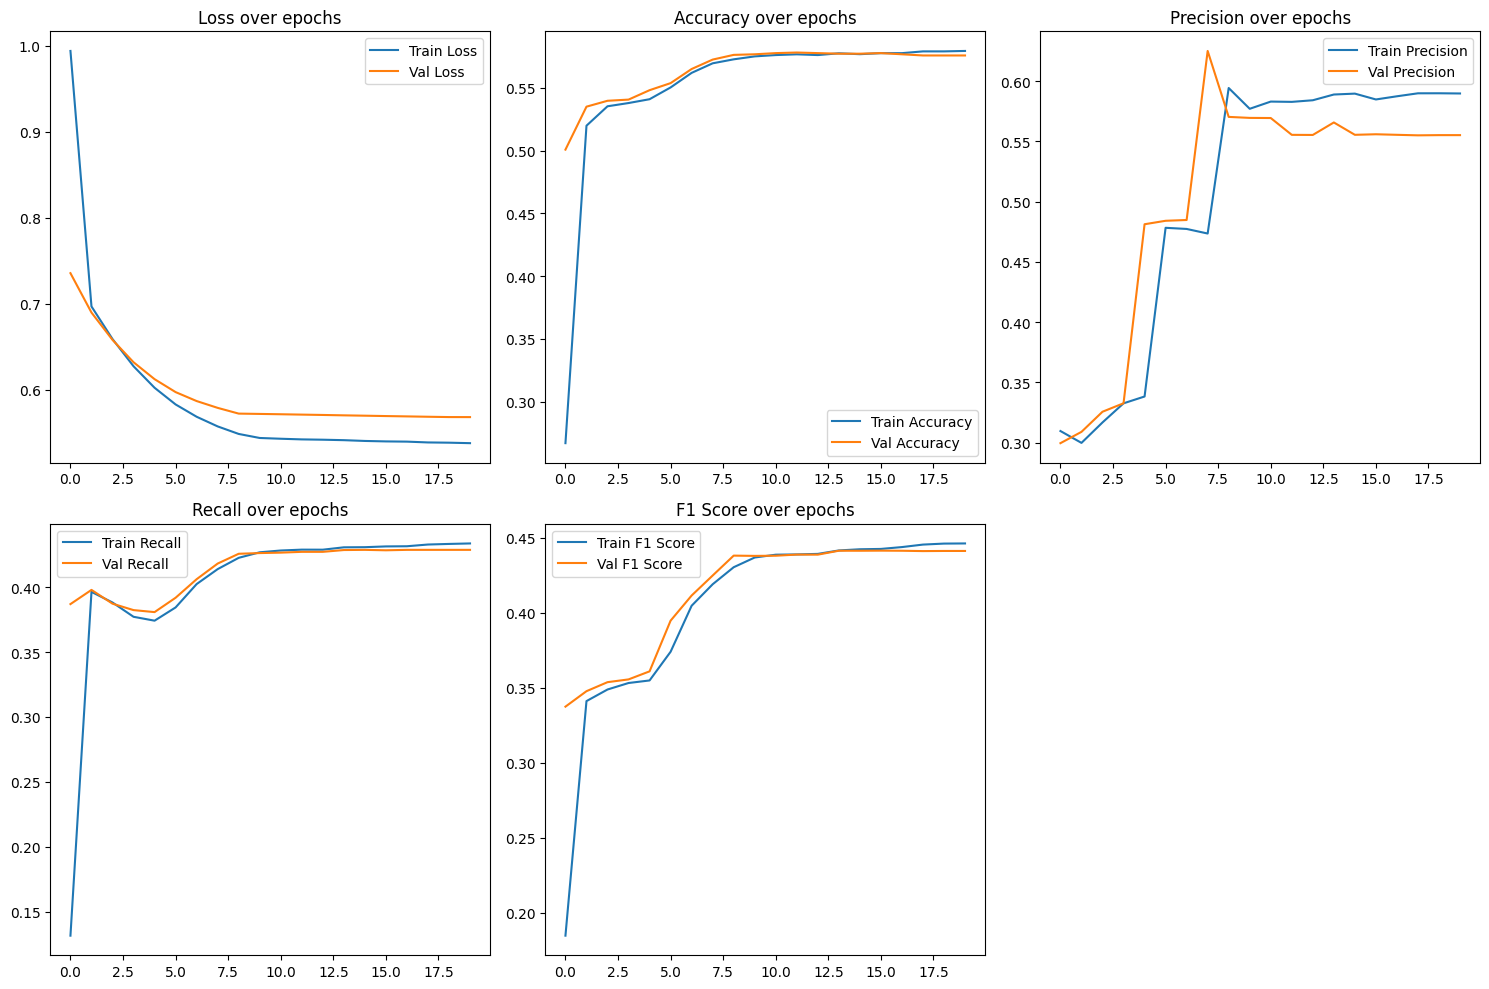

In [ ]:
def plot_history(history):
    plt.figure(figsize=(15, 10))

    # plot loss
    plt.subplot(2, 3, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.title('Loss over epochs')
    plt.legend()

    # plot accuracy
    plt.subplot(2, 3, 2)
    plt.plot(history['train_accuracy'], label='Train Accuracy')
    plt.plot(history['val_accuracy'], label='Val Accuracy')
    plt.title('Accuracy over epochs')
    plt.legend()

    # plot precision
    plt.subplot(2, 3, 3)
    plt.plot(history['train_precision'], label='Train Precision')
    plt.plot(history['val_precision'], label='Val Precision')
    plt.title('Precision over epochs')
    plt.legend()

    # plot recall
    plt.subplot(2, 3, 4)
    plt.plot(history['train_recall'], label='Train Recall')
    plt.plot(history['val_recall'], label='Val Recall')
    plt.title('Recall over epochs')
    plt.legend()

    # plot F1 Score
    plt.subplot(2, 3, 5)
    plt.plot(history['train_f1'], label='Train F1 Score')
    plt.plot(history['val_f1'], label='Val F1 Score')
    plt.title('F1 Score over epochs')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_history(sbert_process_history)


In [ ]:
def load_model(path):
    model = SBertClassifier(embedding_dim, num_labels=7)
    model.load_state_dict(torch.load(path))
    model.to(device)
    model.eval()
    return model

# load the model
sentence_sbert_classifier_model = load_model('./sentence_sbert_model_path.pth')

def predict(text):
    with torch.no_grad():
        embeddings = sentence_sbert_model.encode([text], convert_to_tensor=True).to(device)
        outputs = sentence_sbert_classifier_model(embeddings)
        preds = torch.sigmoid(outputs).cpu().numpy() > 0.8
    return preds

sample_sentence = "We ensure the security of your personal data with up-to-date protocols."
sentence_sbert_prediction = predict(sample_sentence)
print("Prediction:", sentence_sbert_prediction)


Prediction: [[False False False False False  True False]]


### BERT

In [ ]:
sentence_bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
max_len = 512

sentences_dataset = PrivacyPolicySentenceDataset(sentences_df['sentence_text'], sentences_df['sentence_labels'], sentence_bert_tokenizer, max_len)

sentence_bert_train_dataset, sentence_bert_eval_dataset = train_test_split(sentences_dataset, test_size=0.2)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sentence_bert_compute_metrics(eval_pred):
    print(eval_pred)
    logits, labels = eval_pred
    probs = sigmoid(logits)
    preds = (probs > 0.8).astype(int)

    accuracy = accuracy_score(labels, preds)
    precision = precision_score(labels, preds, average='macro', zero_division=0)
    recall = recall_score(labels, preds, average='macro', zero_division=0)
    f1 = f1_score(labels, preds, average='macro', zero_division=0)

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

# add weight distribution to punish class imbalance
total_counts = sum(index_counts)
class_weights = [total_counts / count if count > 0 else 0 for count in index_counts]
max_weight = max(class_weights)
normalized_weights = [x / max_weight for x in class_weights]
weights_tensor = torch.tensor(normalized_weights, dtype=torch.float)

if torch.cuda.is_available():
    weights_tensor = weights_tensor.to('cuda')

class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.get('logits')
        loss_fct = torch.nn.BCEWithLogitsLoss(weight=weights_tensor)
        loss = loss_fct(logits, labels.float())
        return (loss, outputs) if return_outputs else loss

sentence_bert_model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=7)

# training arguments
sentence_bert_training_args = TrainingArguments(
    learning_rate=1e-4,
    output_dir='./sentence_bert_results',
    num_train_epochs=5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./sentence_bert_logs',
    logging_steps=50,
    eval_steps=50,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True
)

# initialize the trainer
sentence_bert_trainer = WeightedTrainer(
    model=sentence_bert_model,
    args=sentence_bert_training_args,
    train_dataset=sentence_bert_train_dataset,
    eval_dataset=sentence_bert_eval_dataset,
    compute_metrics=sentence_bert_compute_metrics
)

sentence_bert_trainer.train()


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


TrainOutput(global_step=5340, training_loss=0.1419697123520383, metrics={'train_runtime': 4272.5506, 'train_samples_per_second': 9.991, 'train_steps_per_second': 1.25, 'total_flos': 1.1231399586432e+16, 'train_loss': 0.1419697123520383, 'epoch': 5.0})

In [ ]:
sentence_bert_trainer.evaluate()


{'eval_loss': 0.19864608347415924,
 'eval_accuracy': 0.6112412177985949,
 'eval_precision': 0.7190588038827616,
 'eval_recall': 0.44868166488311584,
 'eval_f1': 0.5080261414602283,
 'eval_runtime': 63.9909,
 'eval_samples_per_second': 33.364,
 'eval_steps_per_second': 2.094,
 'epoch': 5.0}

In [ ]:
# save the trained model
sentence_bert_model_path = "./sentence_bert_model"
sentence_bert_model.save_pretrained(sentence_bert_model_path)
sentence_bert_tokenizer.save_pretrained(sentence_bert_model_path)


('./sentence_bert_model/tokenizer_config.json',
 './sentence_bert_model/special_tokens_map.json',
 './sentence_bert_model/vocab.txt',
 './sentence_bert_model/added_tokens.json')

In [ ]:
!zip -r sentence_bert_logs.zip sentence_bert_logs/
!zip -r sentence_bert_results.zip sentence_bert_results/
!zip -r sentence_bert_model.zip sentence_bert_model/


updating: sentence_bert_logs/ (stored 0%)
updating: sentence_bert_logs/events.out.tfevents.1718633730.5a2055ebb5be.235.4 (deflated 67%)
updating: sentence_bert_logs/events.out.tfevents.1718638058.5a2055ebb5be.235.5 (deflated 31%)
  adding: sentence_bert_logs/events.out.tfevents.1718657296.5a2055ebb5be.235.12 (deflated 30%)
  adding: sentence_bert_logs/events.out.tfevents.1718652958.5a2055ebb5be.235.11 (deflated 67%)
updating: sentence_bert_results/ (stored 0%)
updating: sentence_bert_results/checkpoint-2136/ (stored 0%)
updating: sentence_bert_results/checkpoint-2136/rng_state.pth (deflated 25%)
updating: sentence_bert_results/checkpoint-2136/scheduler.pt (deflated 56%)
updating: sentence_bert_results/checkpoint-2136/trainer_state.json (deflated 75%)
updating: sentence_bert_results/checkpoint-2136/training_args.bin (deflated 52%)
updating: sentence_bert_results/checkpoint-2136/optimizer.pt (deflated 25%)
updating: sentence_bert_results/checkpoint-2136/model.safetensors (deflated 7%)
up

#### Plots

['train/loss', 'train/grad_norm', 'train/learning_rate', 'train/epoch', 'eval/loss', 'eval/accuracy', 'eval/precision', 'eval/recall', 'eval/f1', 'eval/runtime', 'eval/samples_per_second', 'eval/steps_per_second', 'train/train_runtime', 'train/train_samples_per_second', 'train/train_steps_per_second', 'train/total_flos', 'train/train_loss']


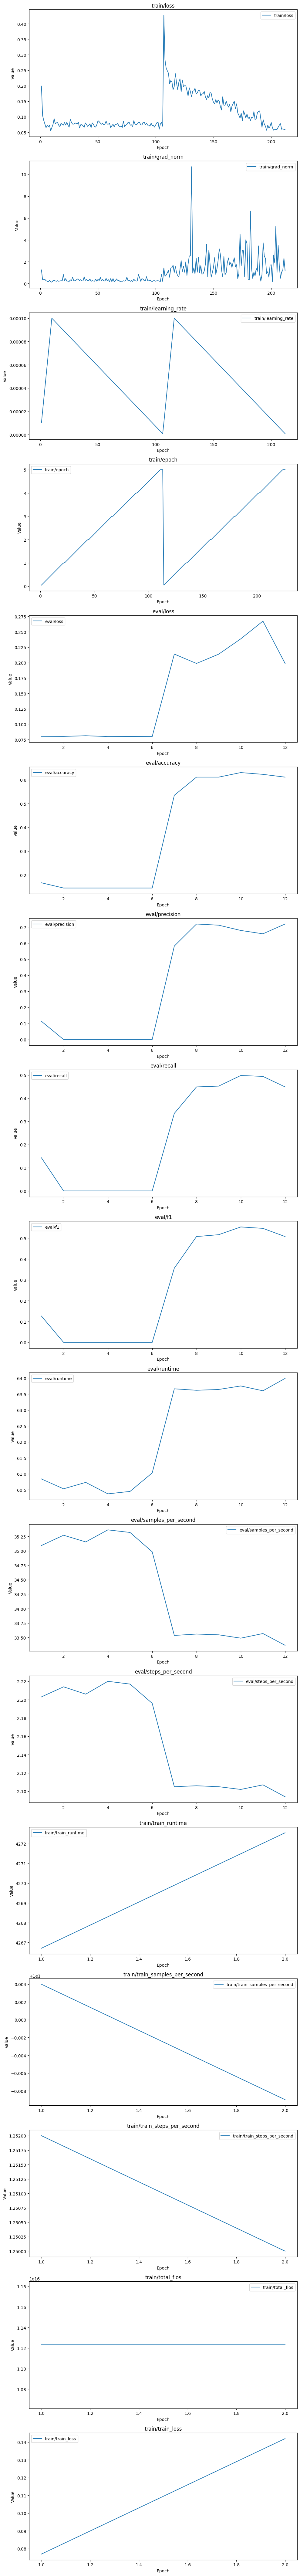

In [ ]:
sentence_bert_logdir = './sentence_bert_logs'

# load the data
ea = event_accumulator.EventAccumulator(sentence_bert_logdir)
ea.Reload()

print(ea.Tags()['scalars'])

def extract_metric(metric_name):
    if metric_name in ea.scalars.Keys():
        return [x.value for x in ea.scalars.Items(metric_name)]
    else:
        return []

metrics_dict = {key: extract_metric(key) for key in ['train/loss',
                                                     'train/grad_norm',
                                                     'train/learning_rate',
                                                     'train/epoch',
                                                     'eval/loss',
                                                     'eval/accuracy',
                                                     'eval/precision',
                                                     'eval/recall', 'eval/f1',
                                                     'eval/runtime',
                                                     'eval/samples_per_second',
                                                     'eval/steps_per_second',
                                                     'train/train_runtime',
                                                     'train/train_samples_per_second',
                                                     'train/train_steps_per_second',
                                                     'train/total_flos', 'train/train_loss']
}

num_plots = len(metrics_dict)

fig, axs = plt.subplots(num_plots, 1, figsize=(10, 5 * num_plots))
axs = axs.flatten()

# plot each metric
for i, (metric, values) in enumerate(metrics_dict.items()):
    epochs = range(1, len(values)+1)
    axs[i].plot(epochs, values, label=metric)
    axs[i].set_title(metric)
    axs[i].set_xlabel('Epoch')
    axs[i].set_ylabel('Value')
    axs[i].legend()

plt.tight_layout()
plt.show()


In [ ]:
sentence_bert_model = BertForSequenceClassification.from_pretrained(sentence_bert_model_path)
sentence_bert_tokenizer = BertTokenizer.from_pretrained(sentence_bert_model_path)

sentence_bert_classifier = pipeline("text-classification", model=sentence_bert_model, tokenizer=sentence_bert_tokenizer)

# text = "Our site includes third-party advertising and links to other Web sites."
text = "We reveal only the last four digits of your credit card numbers when confirming an order."

sentence_bert_predictions = sentence_bert_classifier(text)

if sentence_bert_predictions:
    for pred in sentence_bert_predictions:
        label = label_descriptions.get(pred['label'], "Unknown Label")
        score = pred['score']
        print(f"Prediction: {label}, Score: {score:.4f}")


Prediction: Integrity and Confidentiality (Security), Score: 0.8337


### GPT2

In [ ]:
sentence_gpt_tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
if sentence_gpt_tokenizer.pad_token is None:
    sentence_gpt_tokenizer.pad_token = sentence_gpt_tokenizer.eos_token

max_len = 512

sentences_dataset = PrivacyPolicySentenceDataset(sentences_df['sentence_text'], sentences_df['sentence_labels'], sentence_gpt_tokenizer, max_len)

sentence_gpt_train_dataset, sentence_gpt_eval_dataset = train_test_split(sentences_dataset, test_size=0.2)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sentence_gpt_compute_metrics(eval_pred):
    print(eval_pred)
    logits, labels = eval_pred
    probs = sigmoid(logits)
    preds = (probs > 0.8).astype(int)

    accuracy = accuracy_score(labels, preds)
    precision = precision_score(labels, preds, average='macro', zero_division=0)
    recall = recall_score(labels, preds, average='macro', zero_division=0)
    f1 = f1_score(labels, preds, average='macro', zero_division=0)

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

# add weight distribution to punish class imbalance
total_counts = sum(index_counts)
class_weights = [total_counts / count if count > 0 else 0 for count in index_counts]
max_weight = max(class_weights)
normalized_weights = [x / max_weight for x in class_weights]
weights_tensor = torch.tensor(normalized_weights, dtype=torch.float)

if torch.cuda.is_available():
    weights_tensor = weights_tensor.to('cuda')

class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        outputs = model(**inputs)
        if 'loss' not in outputs:
            labels = inputs.get("labels")
            logits = outputs.get('logits')
            loss_fct = torch.nn.BCEWithLogitsLoss(weight=weights_tensor)
            loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.float().view(-1, self.model.config.num_labels))
        else:
            loss = outputs['loss']

        return (loss, outputs) if return_outputs else loss

# initialize the model
sentence_gpt_model = GPT2ForSequenceClassification.from_pretrained('gpt2', pad_token_id=sentence_gpt_tokenizer.eos_token_id, num_labels=7)
sentence_gpt_model.resize_token_embeddings(len(sentence_gpt_tokenizer))

# training arguments
sentence_gpt_training_args = TrainingArguments(
    learning_rate=1e-4,
    output_dir='./sentence_gpt_results',
    num_train_epochs=5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./sentence_gpt_logs',
    logging_steps=50,
    eval_steps=50,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True
)

# initialize the trainer
sentence_gpt_trainer = WeightedTrainer(
    model=sentence_gpt_model,
    args=sentence_gpt_training_args,
    train_dataset=sentence_gpt_train_dataset,
    eval_dataset=sentence_gpt_eval_dataset,
    compute_metrics=sentence_gpt_compute_metrics
)

sentence_gpt_trainer.train()


Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


TrainOutput(global_step=5340, training_loss=0.2021182017826409, metrics={'train_runtime': 4938.4102, 'train_samples_per_second': 8.643, 'train_steps_per_second': 1.081, 'total_flos': 1.115395533176832e+16, 'train_loss': 0.2021182017826409, 'epoch': 5.0})

In [ ]:
sentence_gpt_trainer.evaluate()


{'eval_loss': 0.2669645845890045,
 'eval_accuracy': 0.5189695550351288,
 'eval_precision': 0.7941088096412047,
 'eval_recall': 0.34354120223637935,
 'eval_f1': 0.42478695001856676,
 'eval_runtime': 71.4173,
 'eval_samples_per_second': 29.895,
 'eval_steps_per_second': 1.876,
 'epoch': 5.0}

In [ ]:
# save the trained model
sentence_gpt_model_path = "./sentence_gpt_model"
sentence_gpt_model.save_pretrained(sentence_gpt_model_path)
sentence_gpt_tokenizer.save_pretrained(sentence_gpt_model_path)


('./sentence_gpt_model/tokenizer_config.json',
 './sentence_gpt_model/special_tokens_map.json',
 './sentence_gpt_model/vocab.json',
 './sentence_gpt_model/merges.txt',
 './sentence_gpt_model/added_tokens.json')

In [ ]:
!zip -r sentence_gpt_logs.zip sentence_gpt_logs/
!zip -r sentence_gpt_results.zip sentence_gpt_results/
!zip -r sentence_gpt_model.zip sentence_gpt_model/


updating: sentence_gpt_logs/ (stored 0%)
updating: sentence_gpt_logs/events.out.tfevents.1718638389.5a2055ebb5be.235.6 (deflated 67%)
updating: sentence_gpt_logs/events.out.tfevents.1718643402.5a2055ebb5be.235.7 (deflated 49%)
updating: sentence_gpt_results/ (stored 0%)
updating: sentence_gpt_results/checkpoint-2136/ (stored 0%)
updating: sentence_gpt_results/checkpoint-2136/rng_state.pth (deflated 25%)
updating: sentence_gpt_results/checkpoint-2136/scheduler.pt (deflated 56%)
updating: sentence_gpt_results/checkpoint-2136/trainer_state.json (deflated 75%)
updating: sentence_gpt_results/checkpoint-2136/training_args.bin (deflated 52%)
updating: sentence_gpt_results/checkpoint-2136/optimizer.pt (deflated 33%)
updating: sentence_gpt_results/checkpoint-2136/model.safetensors (deflated 7%)
updating: sentence_gpt_results/checkpoint-2136/config.json (deflated 57%)
updating: sentence_gpt_results/checkpoint-5340/ (stored 0%)
updating: sentence_gpt_results/checkpoint-5340/rng_state.pth (deflate

#### Plots

['train/loss', 'train/grad_norm', 'train/learning_rate', 'train/epoch', 'eval/loss', 'eval/accuracy', 'eval/precision', 'eval/recall', 'eval/f1', 'eval/runtime', 'eval/samples_per_second', 'eval/steps_per_second', 'train/train_runtime', 'train/train_samples_per_second', 'train/train_steps_per_second', 'train/total_flos', 'train/train_loss']


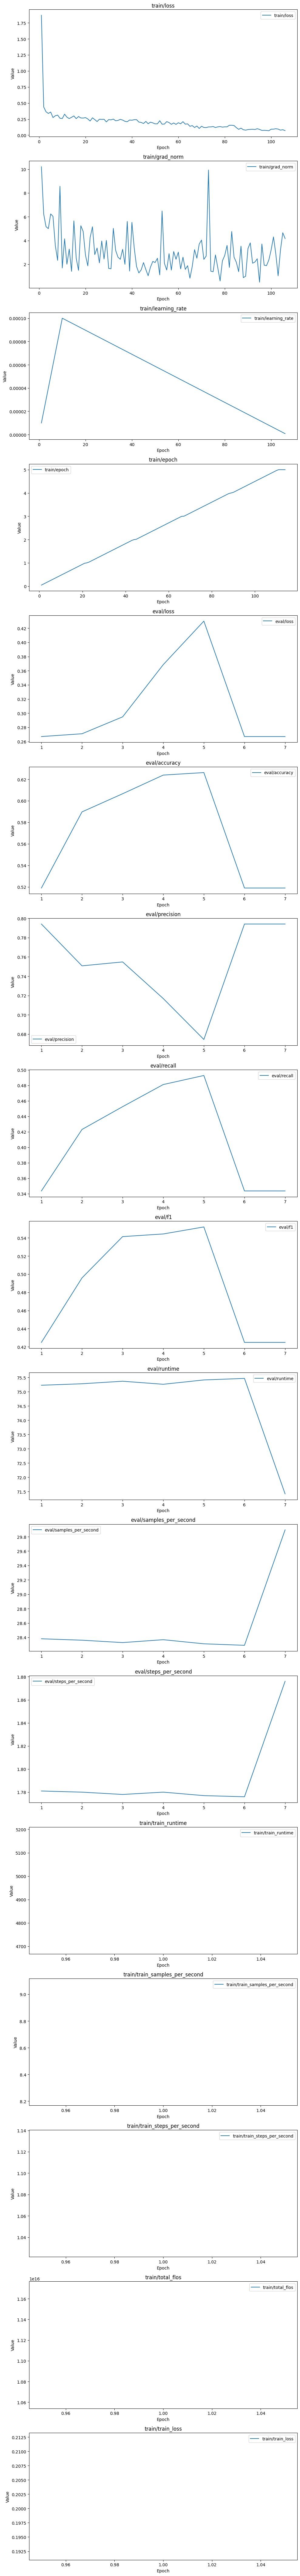

In [ ]:
sentence_gpt_logdir = './sentence_gpt_logs'

# load the data
ea = event_accumulator.EventAccumulator(sentence_gpt_logdir)
ea.Reload()

print(ea.Tags()['scalars'])

def extract_metric(metric_name):
    if metric_name in ea.scalars.Keys():
        return [x.value for x in ea.scalars.Items(metric_name)]
    else:
        return []

metrics_dict = {key: extract_metric(key) for key in ['train/loss',
                                                     'train/grad_norm',
                                                     'train/learning_rate',
                                                     'train/epoch',
                                                     'eval/loss',
                                                     'eval/accuracy',
                                                     'eval/precision',
                                                     'eval/recall', 'eval/f1',
                                                     'eval/runtime',
                                                     'eval/samples_per_second',
                                                     'eval/steps_per_second',
                                                     'train/train_runtime',
                                                     'train/train_samples_per_second',
                                                     'train/train_steps_per_second',
                                                     'train/total_flos', 'train/train_loss']
}

num_plots = len(metrics_dict)

fig, axs = plt.subplots(num_plots, 1, figsize=(10, 5 * num_plots))
axs = axs.flatten()

# plot each metric
for i, (metric, values) in enumerate(metrics_dict.items()):
    epochs = range(1, len(values)+1)
    axs[i].plot(epochs, values, label=metric)
    axs[i].set_title(metric)
    axs[i].set_xlabel('Epoch')
    axs[i].set_ylabel('Value')
    axs[i].legend()

plt.tight_layout()
plt.show()


In [ ]:
sentence_gpt_model = GPT2ForSequenceClassification.from_pretrained(sentence_gpt_model_path)
sentence_gpt_tokenizer = GPT2Tokenizer.from_pretrained(sentence_gpt_model_path)

sentence_gpt_classifier = pipeline("text-classification", model=sentence_gpt_model, tokenizer=sentence_gpt_tokenizer)

# text = "Our site includes third-party advertising and links to other Web sites."
text = "We reveal only the last four digits of your credit card numbers when confirming an order."

# make predictions
sentence_gpt_predictions = sentence_gpt_classifier(text)

if sentence_gpt_predictions:
    for pred in sentence_gpt_predictions:
        label = label_descriptions.get(pred['label'], "Unknown Label")
        score = pred['score']
        print(f"Prediction: {label}, Score: {score:.4f}")


Prediction: Lawfulness, Fairness, and Transparency, Score: 0.4182


## ACL-Coling Dataset

In [ ]:
nlp = spacy.load("en_core_web_sm")

def preprocess_text(text):
    text = ' '.join(text.split()).lower()
    return text

def extract_sentences(text):
    doc = nlp(text)
    return [preprocess_text(sent.text) for sent in doc.sents]

preprocessed_policies_sentences = []
directory = './acl_corpus/corpus/'

for filename in tqdm(os.listdir(directory), desc="Processing files"):
    if filename.endswith('.xml'):
        path = os.path.join(directory, filename)
        tree = ET.parse(path)
        root = tree.getroot()

        policy_sentences = []
        for section in root.findall('.//SECTION/SUBTEXT'):
            if section.text:
                sentences = extract_sentences(section.text)
                policy_sentences.extend(sentences)

        if policy_sentences:
            preprocessed_policies_sentences.append(policy_sentences)
        else:
            print(f"No meaningful content found in {filename}, policy skipped.")

print(f"Number of processed privacy policies: {len(preprocessed_policies_sentences)}")


Processing files: 100%|██████████| 1011/1011 [06:09<00:00,  2.74it/s]

Number of processed privacy policies: 1010


### SBERT (saved model)

In [ ]:
def load_model(path):
    model = SBertClassifier(embedding_dim, num_labels=7)
    model.load_state_dict(torch.load(path))
    model.eval()
    return model

sentence_sbert_classifier_model = load_model('./sentence_sbert_model_path.pth')
sentence_sbert_classifier_model.to(device)


In [ ]:
def sentence_sbert_classify_policy(policy_sentences, classifier, threshold=0.8):
    results = []
    unique_labels = set()

    for sentence in policy_sentences:
        if len(sentence.split()) > 11:
            embedding = sentence_sbert_model.encode(sentence, convert_to_tensor=True).to(device)

            with torch.no_grad():
                outputs = classifier(embedding.unsqueeze(0))
                probs = torch.sigmoid(outputs).squeeze(0)

            sentence_labels = []
            probs = probs.cpu().numpy()
            for idx, score in enumerate(probs):
                if score >= threshold:
                    label = sbert_label_descriptions.get(idx, "Unknown Label")
                    sentence_labels.append((label, score))
                    unique_labels.add(label)

            results.append((sentence, sentence_labels))
    return results, unique_labels


In [ ]:
policy_results, unique_labels = sentence_sbert_classify_policy(preprocessed_policies_sentences[100], sentence_sbert_classifier_model, threshold=0.8)

print("Policy Classification Results:")
for sentence, labels in policy_results:
    print(f"Sentence: {sentence}")
    for label, score in labels:
        print(f"  Prediction: {label}, Score: {score:.4f}")
    print()

print("\nUnique GDPR Labels identified in this policy:")
for label in unique_labels:
    print(label)


Policy Classification Results:
Sentence: yanair website privacy statement ryanair is committed to protecting your privacy, our website privacy statement sets out what information we collect, how we collect it, what we do with it and how we protect this information.
  Prediction: Lawfulness, Fairness and Transparency, Score: 0.9010

Sentence: in order to process your booking, we collect personal details from you.
  Prediction: Lawfulness, Fairness and Transparency, Score: 0.9900
  Prediction: Purpose Limitation, Score: 0.9855
  Prediction: Data Minimization, Score: 0.9854

Sentence: these details may include (where applicable) passenger names, addresses, passport or government issued eu national id card numbers, telephone numbers, e-mail and ip addresses, credit/debit card or other payment details.
  Prediction: Lawfulness, Fairness and Transparency, Score: 0.9699
  Prediction: Purpose Limitation, Score: 0.9630
  Prediction: Data Minimization, Score: 0.9619

Sentence: in some instances 

#### Compliance Report

In [ ]:
best_examples = {}

for sentence, labels in policy_results:
    for label, score in labels:
        if label not in best_examples or score > best_examples[label][1]:
            best_examples[label] = (sentence, score)

compliance_threshold = 0.8

sbert_sentences_policy_results = {}

gdpr_principles = [
    "Lawfulness, Fairness and Transparency",
    "Purpose Limitation",
    "Data Minimization",
    "Accuracy",
    "Storage Limitation",
    "Integrity and Confidentiality",
    "Accountability"
]

for principle in gdpr_principles:
    if principle in best_examples and best_examples[principle][1] >= compliance_threshold:
        sbert_sentences_policy_results[principle] = {
            "compliant": True,
            "example": best_examples[principle][0],
            "score": best_examples[principle][1]
        }
    else:
        sbert_sentences_policy_results[principle] = {"compliant": False}



In [ ]:
def generate_html_report(policy_name, results):
    non_compliant_count = sum(1 for details in results.values() if not details.get("compliant", False))
    total_principles = len(results)

    report_html = f"""
    <html>
    <head>
        <title>GDPR Compliance Report for {policy_name}</title>
        <style>
            body {{ font-family: Arial, sans-serif; margin: 40px; }}
            h1 {{ color: #4CAF50; }}
            h2 {{ color: #2196F3; }}
            p {{ font-size: 16px; }}
            ul {{ list-style-type: none; padding: 0; }}
            li {{ margin-bottom: 10px; }}
            .compliant {{ color: green; }}
            .non-compliant {{ color: red; }}
            .example {{ margin-left: 20px; font-style: italic; }}
        </style>
    </head>
    <body>
        <h1>GDPR Compliance Report for {policy_name}</h1>
        <p><strong>Summary:</strong> Non-compliant with {non_compliant_count} out of {total_principles} principles evaluated.</p>

        <h2>Detailed Findings:</h2>
        <ul>
    """

    for principle, details in results.items():
        compliance_status = "Compliant" if details.get("compliant") else "Non-compliant"
        compliance_class = "compliant" if details.get("compliant") else "non-compliant"
        example_sentence = details.get("example", "Not available")

        report_html += f"""
        <li class="{compliance_class}">{principle}: {compliance_status}</li>
        """
        if details.get("compliant"):
            report_html += f"""
            <div class="example">Example: {example_sentence}</div>
            """

    report_html += "</ul>"

    if non_compliant_count > 0:
        non_compliant_principles = ", ".join([principle for principle, details in results.items() if not details.get("compliant")])
        report_html += f"""
        <h2>Recommendations:</h2>
        <p>Review the policy to align with the following principles:</p>
        <ul>
            <li>{non_compliant_principles}</li>
        </ul>
        """

    report_html += "</body></html>"
    return report_html


sbert_html_content = generate_html_report("yola", sbert_sentences_policy_results)

with open('SBERT_Sentence_Compliance_Report.html', 'w') as file:
    file.write(sbert_html_content)

display(HTML(sbert_html_content))


### BERT (saved model)

In [ ]:
# load the model and tokenizer
sentence_bert_model = BertForSequenceClassification.from_pretrained(sentence_bert_model_path)
sentence_bert_tokenizer = BertTokenizer.from_pretrained(sentence_bert_model_path)

sentence_bert_model.config.output_hidden_states = True


In [ ]:
sentence_bert_classifier = pipeline("text-classification", model=sentence_bert_model, tokenizer=sentence_bert_tokenizer)

def sentence_bert_classify_policy(policy_sentences, threshold=0.8):
    results = []
    unique_labels = set()
    for sentence in policy_sentences:
        if len(sentence.split()) > 11:
            predictions = sentence_bert_classifier(sentence)
            sentence_labels = []
            for pred in predictions:
                if pred['score'] >= threshold:
                    label = label_descriptions.get(pred['label'], "Unknown Label")
                    sentence_labels.append((label, pred['score']))
                    unique_labels.add(label)
            results.append((sentence, sentence_labels))
    return results, unique_labels

# processing and classifying one policy
if preprocessed_policies_sentences:
    policy_results, unique_labels = sentence_bert_classify_policy(preprocessed_policies_sentences[100], threshold=0.8)

    print("Policy Classification Results:")
    for sentence, labels in policy_results:
        print(f"Sentence: {sentence}")
        for label, score in labels:
            print(f"  Prediction: {label}, Score: {score:.4f}")
        print()

    print("\nUnique GDPR Labels identified in this policy:")
    for label in unique_labels:
        print(label)


Policy Classification Results:
Sentence: yanair website privacy statement ryanair is committed to protecting your privacy, our website privacy statement sets out what information we collect, how we collect it, what we do with it and how we protect this information.

Sentence: in order to process your booking, we collect personal details from you.

Sentence: these details may include (where applicable) passenger names, addresses, passport or government issued eu national id card numbers, telephone numbers, e-mail and ip addresses, credit/debit card or other payment details.

Sentence: in some instances we may also collect information regarding medical conditions (only for passengers who have special medical requirements) which may affect the chosen flight arrangements.

Sentence: your data may be used for the following purposes: contacting you in the event of a flight time change or cancellation, credit or other payment card verification/screening, immigration/customs control safety, se

#### Compliance Report

In [ ]:
best_examples = {}

for sentence, labels in policy_results:
    for label, score in labels:
        if label not in best_examples or score > best_examples[label][1]:
            best_examples[label] = (sentence, score)

compliance_threshold = 0.8

bert_sentences_policy_results = {}

gdpr_principles = [
    "Lawfulness, Fairness, and Transparency",
    "Purpose Limitation",
    "Data Minimization",
    "Accuracy",
    "Storage Limitation",
    "Integrity and Confidentiality (Security)",
    "Accountability"
]

for principle in gdpr_principles:
    if principle in best_examples and best_examples[principle][1] >= compliance_threshold:
        bert_sentences_policy_results[principle] = {
            "compliant": True,
            "example": best_examples[principle][0],
            "score": best_examples[principle][1]
        }
    else:
        bert_sentences_policy_results[principle] = {"compliant": False}

bert_html_content = generate_html_report("yola", bert_sentences_policy_results)

with open('BERT_Sentence_Compliance_Report.html', 'w') as file:
    file.write(bert_html_content)

display(HTML(bert_html_content))


### GPT2 (saved model)

In [ ]:
# load the model and tokenizer
sentence_gpt_model = GPT2ForSequenceClassification.from_pretrained(sentence_gpt_model_path)
sentence_gpt_tokenizer = GPT2Tokenizer.from_pretrained(sentence_gpt_model_path)

sentence_gpt_model.config.output_hidden_states = True


In [ ]:
sentence_gpt_classifier = pipeline("text-classification", model=sentence_gpt_model, tokenizer=sentence_gpt_tokenizer)

def sentence_gpt_classify_policy(policy_sentences, threshold=0.8):
    results = []
    unique_labels = set()
    for sentence in policy_sentences:
        if len(sentence.split()) > 11:
            predictions = sentence_gpt_classifier(sentence)
            sentence_labels = []
            for pred in predictions:
                if pred['score'] >= threshold:
                    label = label_descriptions.get(pred['label'], "Unknown Label")
                    sentence_labels.append((label, pred['score']))
                    unique_labels.add(label)
            results.append((sentence, sentence_labels))
    return results, unique_labels

# processing and classifying one policy
if preprocessed_policies_sentences:
    policy_results, unique_labels = sentence_gpt_classify_policy(preprocessed_policies_sentences[100], threshold=0.8)

    print("Policy Classification Results:")
    for sentence, labels in policy_results:
        print(f"Sentence: {sentence}")
        for label, score in labels:
            print(f"  Prediction: {label}, Score: {score:.4f}")
        print()

    print("\nUnique GDPR Labels identified in this policy:")
    for label in unique_labels:
        print(label)


Policy Classification Results:
Sentence: yanair website privacy statement ryanair is committed to protecting your privacy, our website privacy statement sets out what information we collect, how we collect it, what we do with it and how we protect this information.

Sentence: in order to process your booking, we collect personal details from you.
  Prediction: Lawfulness, Fairness, and Transparency, Score: 0.9641

Sentence: these details may include (where applicable) passenger names, addresses, passport or government issued eu national id card numbers, telephone numbers, e-mail and ip addresses, credit/debit card or other payment details.
  Prediction: Lawfulness, Fairness, and Transparency, Score: 0.9077

Sentence: in some instances we may also collect information regarding medical conditions (only for passengers who have special medical requirements) which may affect the chosen flight arrangements.
  Prediction: Lawfulness, Fairness, and Transparency, Score: 0.9845

Sentence: your d

#### Compliance Report

In [ ]:
best_examples = {}

for sentence, labels in policy_results:
    for label, score in labels:
        if label not in best_examples or score > best_examples[label][1]:
            best_examples[label] = (sentence, score)

compliance_threshold = 0.8

gpt_sentences_policy_results = {}

gdpr_principles = [
    "Lawfulness, Fairness, and Transparency",
    "Purpose Limitation",
    "Data Minimization",
    "Accuracy",
    "Storage Limitation",
    "Integrity and Confidentiality (Security)",
    "Accountability"
]

for principle in gdpr_principles:
    if principle in best_examples and best_examples[principle][1] >= compliance_threshold:
        gpt_sentences_policy_results[principle] = {
            "compliant": True,
            "example": best_examples[principle][0],
            "score": best_examples[principle][1]
        }
    else:
        gpt_sentences_policy_results[principle] = {"compliant": False}

gpt_html_content = generate_html_report("yola", gpt_sentences_policy_results)

with open('GPT_Sentence_Compliance_Report.html', 'w') as file:
    file.write(gpt_html_content)

display(HTML(gpt_html_content))


# Policy Level

In [ ]:
policies_df = pd.read_csv('./policies_gdpr_labels.csv')
policies_df['policies_labels'] = policies_df['policies_labels'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
policies_df.head()


source                                      policies_text  \
0          google.com    welcome to the google privacy policy        ...   
1           style.com    vi.privacy policy          the type of infor...   
2   cariboucoffee.com  your privacy     |||caribou coffee privacy sta...   
3         thehill.com    the hill 's privacy policy        this priva...   
4  washingtonpost.com  publish january 1 2015     |||the wp company l...   

                                          categories        policies_labels  \
0  ['Data Security', 'Other', 'User Choice/Contro...  [1, 1, 1, 1, 1, 1, 0]   
1  ['Data Security', 'Do Not Track', 'Other', 'Us...  [1, 1, 1, 1, 0, 1, 0]   
2  ['Data Security', 'Other', 'User Choice/Contro...  [1, 1, 1, 1, 1, 1, 0]   
3  ['Data Security', 'Other', 'User Choice/Contro...  [1, 1, 1, 1, 1, 1, 0]   
4  ['Data Security', 'Do Not Track', 'Other', 'Us...  [1, 1, 1, 1, 0, 1, 0]   

   compliance_percentage  
0              85.714286  
1              71.428571  
2              85.714286  
3              85.714286  
4              71.428571

## OPP-115 Dataset

In [ ]:
n_gdpr = 7  # number of GDPR categories

index_counts = [0] * n_gdpr

for labels in policies_df['policies_labels']:
    for i in range(n_gdpr):
        if labels[i] == 1:
            index_counts[i] += 1

for i, count in enumerate(index_counts):
    print(f"(GDPR Principle {i+1}) count: {count}")

(GDPR Principle 1) count: 115
(GDPR Principle 2) count: 115
(GDPR Principle 3) count: 115
(GDPR Principle 4) count: 90
(GDPR Principle 5) count: 76
(GDPR Principle 6) count: 102
(GDPR Principle 7) count: 0


In [ ]:
class PrivacyPolicyDataset(Dataset):
    def __init__(self, policies_text, labels, tokenizer, max_len):
        """
        Args:
            policies_text (list of str): Texts of multiple policies.
            labels (list of list of int): Labels for each policy.
            tokenizer: Tokenizer to be used for encoding the text.
            max_len (int): Maximum length of the tokens.
        """
        self.tokenizer = tokenizer
        self.policies_text = policies_text
        self.labels = labels
        self.max_len = max_len

    def __len__(self):
        return len(self.policies_text)

    def __getitem__(self, idx):
        encoding = self.tokenizer.encode_plus(
            self.policies_text[idx],
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(self.labels[idx], dtype=torch.float)
        }


### SBERT

In [ ]:
# load SBERT model
policy_sbert_model = SentenceTransformer('all-MiniLM-L6-v2')

def policy_sbert_generate_embeddings(texts):
    embeddings = policy_sbert_model.encode(texts, convert_to_tensor=True)
    return embeddings


def policy_sbert_calculate_metrics(preds, labels):
    accuracy = accuracy_score(labels, preds)
    precision = precision_score(labels, preds, average='macro', zero_division=0)
    recall = recall_score(labels, preds, average='macro', zero_division=0)
    f1 = f1_score(labels, preds, average='macro', zero_division=0)
    return accuracy, precision, recall, f1


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [ ]:
class SBERTPolicyEmbeddingDataset(Dataset):
    def __init__(self, texts, labels):
        self.embeddings = policy_sbert_generate_embeddings(texts)
        self.labels = labels

    def __len__(self):
        return len(self.embeddings)

    def __getitem__(self, idx):
        return {
            'embeddings': self.embeddings[idx],
            'labels': torch.tensor(self.labels[idx], dtype=torch.float)
        }


In [ ]:
def train(model, train_loader, val_loader, optimizer, criterion, scheduler, epochs, device):
    history = {
        'train_loss': [], 'val_loss': [],
        'train_accuracy': [], 'val_accuracy': [],
        'train_precision': [], 'val_precision': [],
        'train_recall': [], 'val_recall': [],
        'train_f1': [], 'val_f1': []
    }


    for epoch in range(epochs):
        model.train()
        total_loss = 0
        all_train_preds = []
        all_train_labels = []
        scheduler.step()

        for batch in train_loader:
            optimizer.zero_grad()
            embeddings = batch['embeddings'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(embeddings)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            train_preds = torch.sigmoid(outputs).detach().cpu().numpy() > 0.5
            all_train_preds.append(train_preds)
            all_train_labels.append(labels.cpu().numpy())

        avg_train_loss = total_loss / len(train_loader)
        history['train_loss'].append(avg_train_loss)

        all_train_preds = np.vstack(all_train_preds)
        all_train_labels = np.vstack(all_train_labels)
        train_accuracy, train_precision, train_recall, train_f1 = policy_sbert_calculate_metrics(all_train_preds, all_train_labels)
        history['train_accuracy'].append(train_accuracy)
        history['train_precision'].append(train_precision)
        history['train_recall'].append(train_recall)
        history['train_f1'].append(train_f1)

        model.eval()
        total_eval_loss = 0
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for batch in val_loader:
                embeddings = batch['embeddings'].to(device)
                labels = batch['labels'].to(device)
                outputs = model(embeddings)
                loss = criterion(outputs, labels)
                total_eval_loss += loss.item()
                preds = torch.sigmoid(outputs).cpu().numpy() > 0.5
                all_preds.append(preds)
                all_labels.append(labels.cpu().numpy())

        avg_val_loss = total_eval_loss / len(val_loader)
        history['val_loss'].append(avg_val_loss)

        all_preds = np.vstack(all_preds)
        all_labels = np.vstack(all_labels)

        val_accuracy, val_precision, val_recall, val_f1 = policy_sbert_calculate_metrics(all_preds, all_labels)
        history['val_accuracy'].append(val_accuracy)
        history['val_precision'].append(val_precision)
        history['val_recall'].append(val_recall)
        history['val_f1'].append(val_f1)

        print(f'Epoch {epoch+1}: Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')
        print(f'Train Accuracy: {train_accuracy:.4f}, Train Precision: {train_precision:.4f}, Train Recall: {train_recall:.4f}, Train F1: {train_f1:.4f}')
        print(f'Val Accuracy: {val_accuracy:.4f}, Val Precision: {val_precision:.4f}, Val Recall: {val_recall:.4f}, Val F1: {val_f1:.4f}')

    return model, history


In [ ]:
class SBertPolicyClassifier(nn.Module):
    def __init__(self, embedding_dim, num_labels, hidden_dim=256):
        super(SBertPolicyClassifier, self).__init__()
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=True, num_layers=2)
        self.attention = nn.Linear(2 * hidden_dim, 1)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(2 * hidden_dim, num_labels)

    def forward(self, embeddings):
        lstm_out, (hidden, _) = self.lstm(embeddings.unsqueeze(1))
        attention_weights = torch.tanh(self.attention(lstm_out))
        context_vector = torch.sum(attention_weights * lstm_out, dim=1)
        context_vector = self.dropout(context_vector)
        out = self.fc(context_vector)
        return out

# initialize the datatset
policy_sbert_dataset = SBERTPolicyEmbeddingDataset(policies_df['policies_text'], policies_df['policies_labels'])
policy_sbert_train_dataset, policy_sbert_eval_dataset = train_test_split(policy_sbert_dataset, test_size=0.2)

policy_sbert_train_loader = DataLoader(policy_sbert_train_dataset, batch_size=16, shuffle=True)
policy_sbert_val_loader = DataLoader(policy_sbert_eval_dataset, batch_size=16, shuffle=False)

policies_labels = np.vstack(policies_df['policies_labels'].values)

class_weights = []

for i in range(policies_labels.shape[1]):
    if np.unique(policies_labels[:, i]).size > 1:
        weights = compute_class_weight('balanced', classes=[0, 1], y=policies_labels[:, i])
        class_weights.append(weights)
    else:
        class_weights.append(np.array([1.0, 1.0]))

mean_weights = np.mean(class_weights, axis=0)
weights_tensor = torch.tensor(mean_weights, dtype=torch.float, device=device)

policy_sbert_criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(mean_weights[1], device=device))

# initialize and train the model
embedding_dim = policy_sbert_model.get_sentence_embedding_dimension()
policy_sbert_classifier_model = SBertPolicyClassifier(embedding_dim, num_labels=7).to(device)
policy_sbert_optimizer = Adam(policy_sbert_classifier_model.parameters(), lr=1e-4)
policy_sbert_scheduler = StepLR(policy_sbert_optimizer, step_size=10, gamma=0.1)

# start the training process
trained_model, sbert_process_history = train(policy_sbert_classifier_model, policy_sbert_train_loader,
                      policy_sbert_val_loader, policy_sbert_optimizer,
                      policy_sbert_criterion, policy_sbert_scheduler, epochs=10, device=device)



Epoch 1: Train Loss: 0.6153, Val Loss: 0.6133
Train Accuracy: 0.0000, Train Precision: 0.4130, Train Recall: 0.2919, Train F1: 0.2894
Val Accuracy: 0.0000, Val Precision: 0.4099, Val Recall: 0.4161, Val F1: 0.4121
Epoch 2: Train Loss: 0.6151, Val Loss: 0.6129
Train Accuracy: 0.0000, Train Precision: 0.4130, Train Recall: 0.4099, Train F1: 0.4104
Val Accuracy: 0.0000, Val Precision: 0.4099, Val Recall: 0.4286, Val F1: 0.4186
Epoch 3: Train Loss: 0.6145, Val Loss: 0.6124
Train Accuracy: 0.0000, Train Precision: 0.4130, Train Recall: 0.4286, Train F1: 0.4204
Val Accuracy: 0.0000, Val Precision: 0.4099, Val Recall: 0.4286, Val F1: 0.4186
Epoch 4: Train Loss: 0.6141, Val Loss: 0.6116
Train Accuracy: 0.0000, Train Precision: 0.4130, Train Recall: 0.4286, Train F1: 0.4204
Val Accuracy: 0.0000, Val Precision: 0.4099, Val Recall: 0.4286, Val F1: 0.4186
Epoch 5: Train Loss: 0.6131, Val Loss: 0.6105
Train Accuracy: 0.0000, Train Precision: 0.4130, Train Recall: 0.4286, Train F1: 0.4204
Val Accura

In [ ]:
# save the trained model
def save_model(model, path):
    torch.save(model.state_dict(), path)

save_model(policy_sbert_classifier_model, './policy_sbert_model_path.pth')


In [ ]:
!zip -r policy_sbert_model.zip policy_sbert_model/


#### Plots

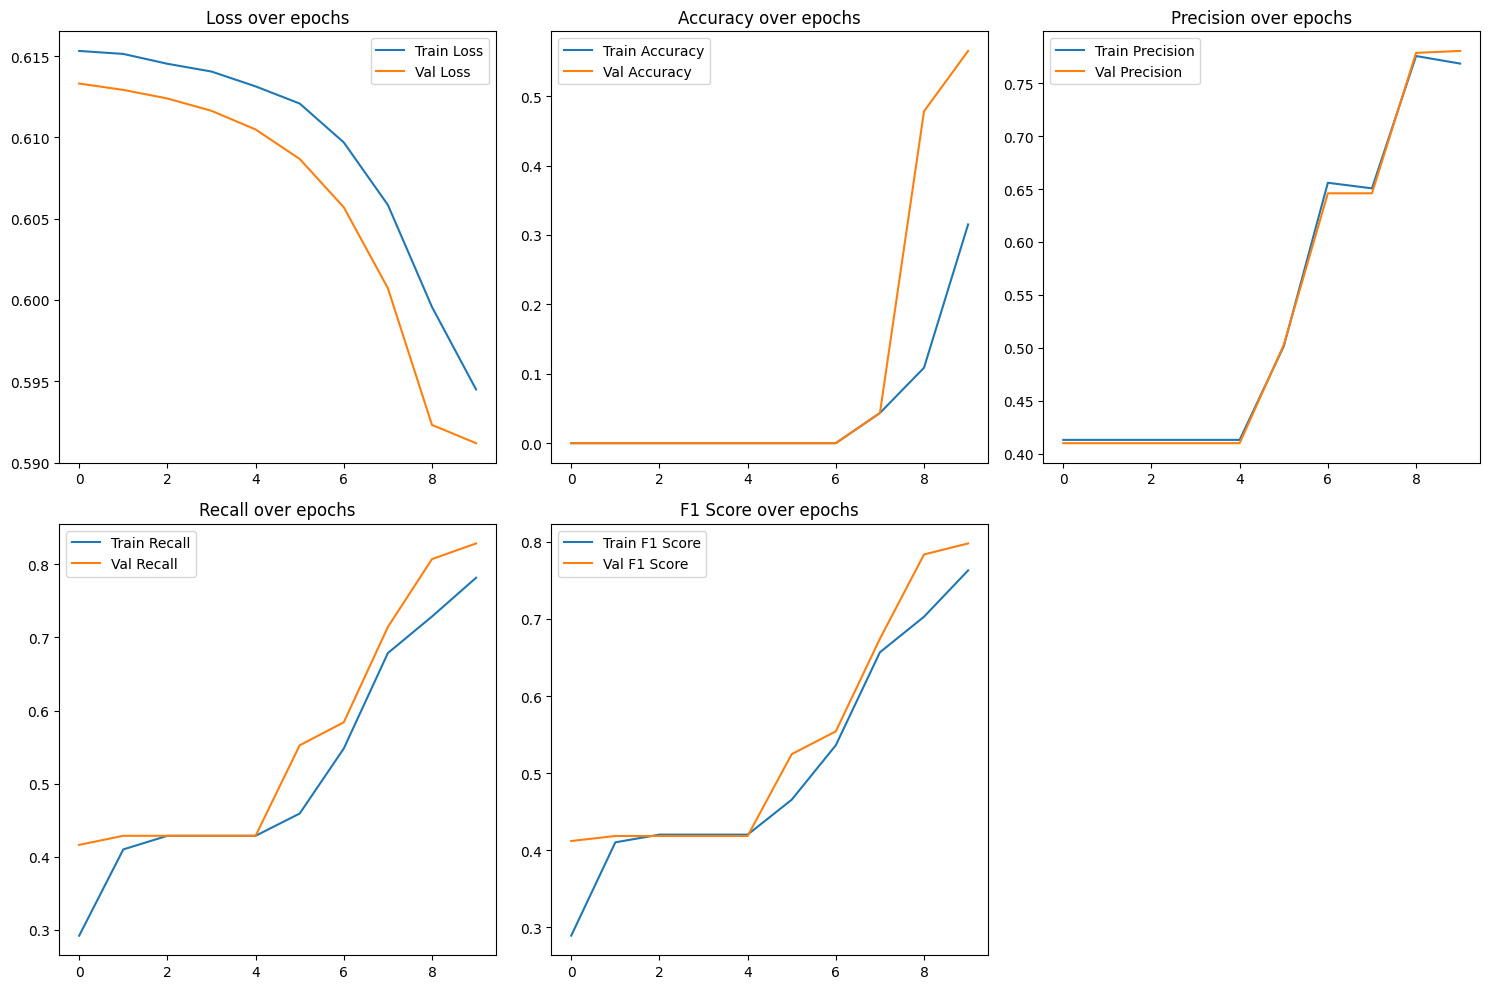

In [ ]:
plot_history(sbert_process_history)


### BERT

In [ ]:
policy_bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
max_len = 512

# initialize the dataset
policies_dataset = PrivacyPolicyDataset(policies_df['policies_text'], policies_df['policies_labels'], policy_bert_tokenizer, max_len)

policy_bert_train_dataset, policy_bert_eval_dataset = train_test_split(policies_dataset, test_size=0.2)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def policy_bert_compute_metrics(eval_pred):
    print(eval_pred)
    logits, labels = eval_pred
    probs = sigmoid(logits)
    preds = (probs > 0.8).astype(int)

    accuracy = accuracy_score(labels, preds)
    precision = precision_score(labels, preds, average='macro', zero_division=0)
    recall = recall_score(labels, preds, average='macro', zero_division=0)
    f1 = f1_score(labels, preds, average='macro', zero_division=0)

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

# initialize the model
policy_bert_model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=7)

# training arguments
policy_bert_training_args = TrainingArguments(
    learning_rate=2e-4,
    output_dir='./policy_bert_results',
    num_train_epochs=15,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./policy_bert_logs',
    logging_steps=50,
    eval_steps=50,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True
)

# initialize the trainer
policy_bert_trainer = Trainer(
    model=policy_bert_model,
    args=policy_bert_training_args,
    train_dataset=policy_bert_train_dataset,
    eval_dataset=policy_bert_eval_dataset,
    compute_metrics=policy_bert_compute_metrics
)

policy_bert_trainer.train()


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


TrainOutput(global_step=180, training_loss=0.2536216033829583, metrics={'train_runtime': 176.9491, 'train_samples_per_second': 7.799, 'train_steps_per_second': 1.017, 'total_flos': 363109556736000.0, 'train_loss': 0.2536216033829583, 'epoch': 15.0})

In [ ]:
policy_bert_trainer.evaluate()


{'eval_loss': 0.24066029489040375,
 'eval_accuracy': 0.17391304347826086,
 'eval_precision': 0.8078007518796992,
 'eval_recall': 0.712484993997599,
 'eval_f1': 0.7094402673350041,
 'eval_runtime': 0.6954,
 'eval_samples_per_second': 33.072,
 'eval_steps_per_second': 2.876,
 'epoch': 15.0}

In [ ]:
# save the trained model
policy_bert_model_path = "./policy_bert_model"
policy_bert_model.save_pretrained(policy_bert_model_path)
policy_bert_tokenizer.save_pretrained(policy_bert_model_path)


('./policy_bert_model/tokenizer_config.json',
 './policy_bert_model/special_tokens_map.json',
 './policy_bert_model/vocab.txt',
 './policy_bert_model/added_tokens.json')

In [ ]:
!zip -r policy_bert_logs.zip policy_bert_logs/
!zip -r policy_bert_results.zip policy_bert_results/
!zip -r policy_bert_model.zip policy_bert_model/


updating: policy_bert_logs/ (stored 0%)
updating: policy_bert_logs/events.out.tfevents.1718644097.5a2055ebb5be.235.8 (deflated 64%)
updating: policy_bert_logs/events.out.tfevents.1718644275.5a2055ebb5be.235.9 (deflated 49%)
updating: policy_bert_results/ (stored 0%)
updating: policy_bert_results/checkpoint-96/ (stored 0%)
updating: policy_bert_results/checkpoint-96/rng_state.pth (deflated 25%)
updating: policy_bert_results/checkpoint-96/scheduler.pt (deflated 56%)
updating: policy_bert_results/checkpoint-96/trainer_state.json (deflated 75%)
updating: policy_bert_results/checkpoint-96/training_args.bin (deflated 52%)
updating: policy_bert_results/checkpoint-96/optimizer.pt (deflated 26%)
updating: policy_bert_results/checkpoint-96/model.safetensors (deflated 7%)
updating: policy_bert_results/checkpoint-96/config.json (deflated 55%)
updating: policy_bert_results/checkpoint-84/ (stored 0%)
updating: policy_bert_results/checkpoint-84/rng_state.pth (deflated 25%)
updating: policy_bert_resul

#### Plots

['eval/loss', 'eval/accuracy', 'eval/precision', 'eval/recall', 'eval/f1', 'eval/runtime', 'eval/samples_per_second', 'eval/steps_per_second', 'train/epoch', 'train/loss', 'train/grad_norm', 'train/learning_rate', 'train/train_runtime', 'train/train_samples_per_second', 'train/train_steps_per_second', 'train/total_flos', 'train/train_loss']


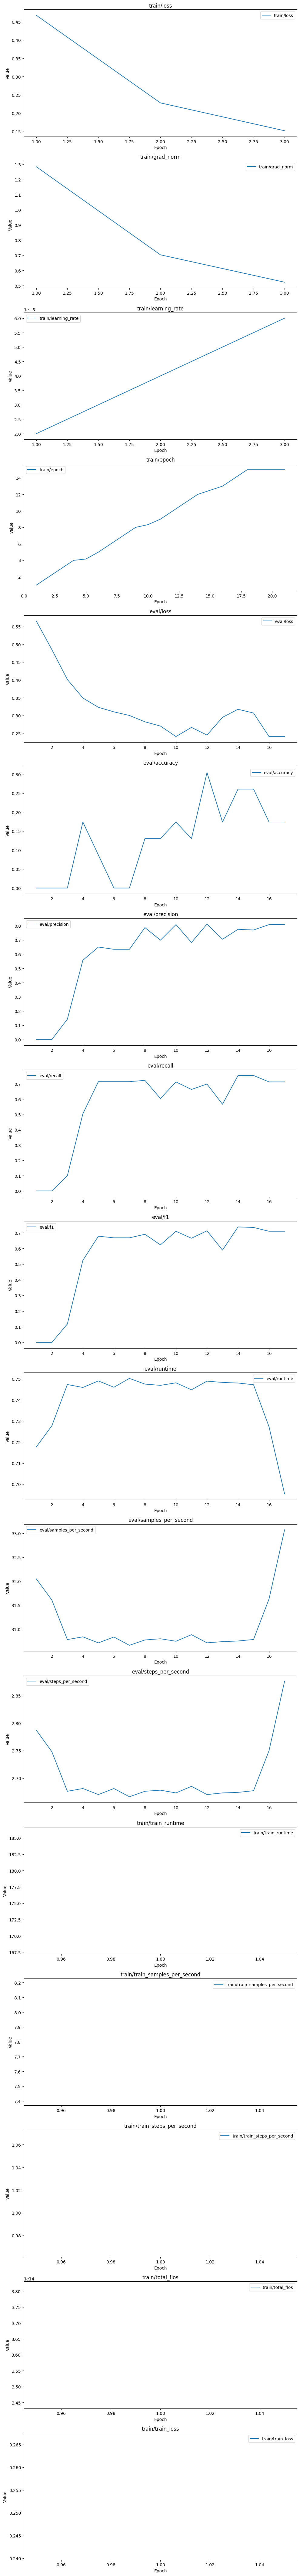

In [ ]:
policy_bert_logdir = './policy_bert_logs'

# load the data
ea = event_accumulator.EventAccumulator(policy_bert_logdir)
ea.Reload()

print(ea.Tags()['scalars'])

def extract_metric(metric_name):
    if metric_name in ea.scalars.Keys():
        return [x.value for x in ea.scalars.Items(metric_name)]
    else:
        return []

metrics_dict = {key: extract_metric(key) for key in ['train/loss',
                                                     'train/grad_norm',
                                                     'train/learning_rate',
                                                     'train/epoch',
                                                     'eval/loss',
                                                     'eval/accuracy',
                                                     'eval/precision',
                                                     'eval/recall', 'eval/f1',
                                                     'eval/runtime',
                                                     'eval/samples_per_second',
                                                     'eval/steps_per_second',
                                                     'train/train_runtime',
                                                     'train/train_samples_per_second',
                                                     'train/train_steps_per_second',
                                                     'train/total_flos', 'train/train_loss']
}

num_plots = len(metrics_dict)

fig, axs = plt.subplots(num_plots, 1, figsize=(10, 5 * num_plots))
axs = axs.flatten()

# plot each metric
for i, (metric, values) in enumerate(metrics_dict.items()):
    epochs = range(1, len(values)+1)
    axs[i].plot(epochs, values, label=metric)
    axs[i].set_title(metric)
    axs[i].set_xlabel('Epoch')
    axs[i].set_ylabel('Value')
    axs[i].legend()

plt.tight_layout()
plt.show()


### GPT2

In [ ]:
policy_gpt_tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
if policy_gpt_tokenizer.pad_token is None:
    policy_gpt_tokenizer.pad_token = policy_gpt_tokenizer.eos_token
max_len = 512

policies_dataset = PrivacyPolicyDataset(policies_df['policies_text'], policies_df['policies_labels'], policy_gpt_tokenizer, max_len)

policy_gpt_train_dataset, policy_gpt_eval_dataset = train_test_split(policies_dataset, test_size=0.2)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def policy_gpt_compute_metrics(eval_pred):
    print(eval_pred)
    logits, labels = eval_pred
    probs = sigmoid(logits)
    preds = (probs > 0.8).astype(int)

    accuracy = accuracy_score(labels, preds)
    precision = precision_score(labels, preds, average='macro', zero_division=0)
    recall = recall_score(labels, preds, average='macro', zero_division=0)
    f1 = f1_score(labels, preds, average='macro', zero_division=0)

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

# initialize the model
policy_gpt_model = GPT2ForSequenceClassification.from_pretrained('gpt2', pad_token_id=policy_gpt_tokenizer.eos_token_id, num_labels=7)
policy_gpt_model.resize_token_embeddings(len(policy_gpt_tokenizer))

# training arguments
policy_gpt_training_args = TrainingArguments(
    learning_rate=2e-4,
    output_dir='./policy_gpt_results',
    num_train_epochs=15,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./policy_gpt_logs',
    logging_steps=50,
    eval_steps=50,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True
)

# initialize the trainer
policy_gpt_trainer = Trainer(
    model=policy_gpt_model,
    args=policy_gpt_training_args,
    train_dataset=policy_gpt_train_dataset,
    eval_dataset=policy_gpt_eval_dataset,
    compute_metrics=policy_gpt_compute_metrics
)

policy_gpt_trainer.train()


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


TrainOutput(global_step=180, training_loss=0.43988445467419096, metrics={'train_runtime': 207.1046, 'train_samples_per_second': 6.663, 'train_steps_per_second': 0.869, 'total_flos': 360605794959360.0, 'train_loss': 0.43988445467419096, 'epoch': 15.0})

In [ ]:
policy_gpt_trainer.evaluate()


{'eval_loss': 0.19826145470142365,
 'eval_accuracy': 0.6086956521739131,
 'eval_precision': 0.8029401154401155,
 'eval_recall': 0.7955745341614907,
 'eval_f1': 0.7985395035207067,
 'eval_runtime': 0.8593,
 'eval_samples_per_second': 26.766,
 'eval_steps_per_second': 2.327,
 'epoch': 15.0}

In [ ]:
# save the trained model
policy_gpt_model_path = "./policy_gpt_model"
policy_gpt_model.save_pretrained(policy_gpt_model_path)
policy_gpt_tokenizer.save_pretrained(policy_gpt_model_path)


('./policy_gpt_model/tokenizer_config.json',
 './policy_gpt_model/special_tokens_map.json',
 './policy_gpt_model/vocab.json',
 './policy_gpt_model/merges.txt',
 './policy_gpt_model/added_tokens.json')

In [ ]:
!zip -r policy_gpt_logs.zip policy_gpt_logs/
!zip -r policy_gpt_results.zip policy_gpt_results/
!zip -r policy_gpt_model.zip policy_gpt_model/


  adding: policy_gpt_logs/ (stored 0%)
  adding: policy_gpt_logs/events.out.tfevents.1718683265.b43a16859ef6.301.1 (deflated 29%)
  adding: policy_gpt_logs/events.out.tfevents.1718682898.b43a16859ef6.301.0 (deflated 64%)
  adding: policy_gpt_results/ (stored 0%)
  adding: policy_gpt_results/checkpoint-72/ (stored 0%)
  adding: policy_gpt_results/checkpoint-72/scheduler.pt (deflated 56%)
  adding: policy_gpt_results/checkpoint-72/training_args.bin (deflated 52%)
  adding: policy_gpt_results/checkpoint-72/model.safetensors (deflated 7%)
  adding: policy_gpt_results/checkpoint-72/config.json (deflated 57%)
  adding: policy_gpt_results/checkpoint-72/trainer_state.json (deflated 70%)
  adding: policy_gpt_results/checkpoint-72/rng_state.pth (deflated 25%)
  adding: policy_gpt_results/checkpoint-72/optimizer.pt (deflated 35%)
  adding: policy_gpt_results/checkpoint-144/ (stored 0%)
  adding: policy_gpt_results/checkpoint-144/scheduler.pt (deflated 56%)
  adding: policy_gpt_results/checkpoint-

#### Plots

['eval/loss', 'eval/accuracy', 'eval/precision', 'eval/recall', 'eval/f1', 'eval/runtime', 'eval/samples_per_second', 'eval/steps_per_second', 'train/epoch', 'train/loss', 'train/grad_norm', 'train/learning_rate', 'train/train_runtime', 'train/train_samples_per_second', 'train/train_steps_per_second', 'train/total_flos', 'train/train_loss']


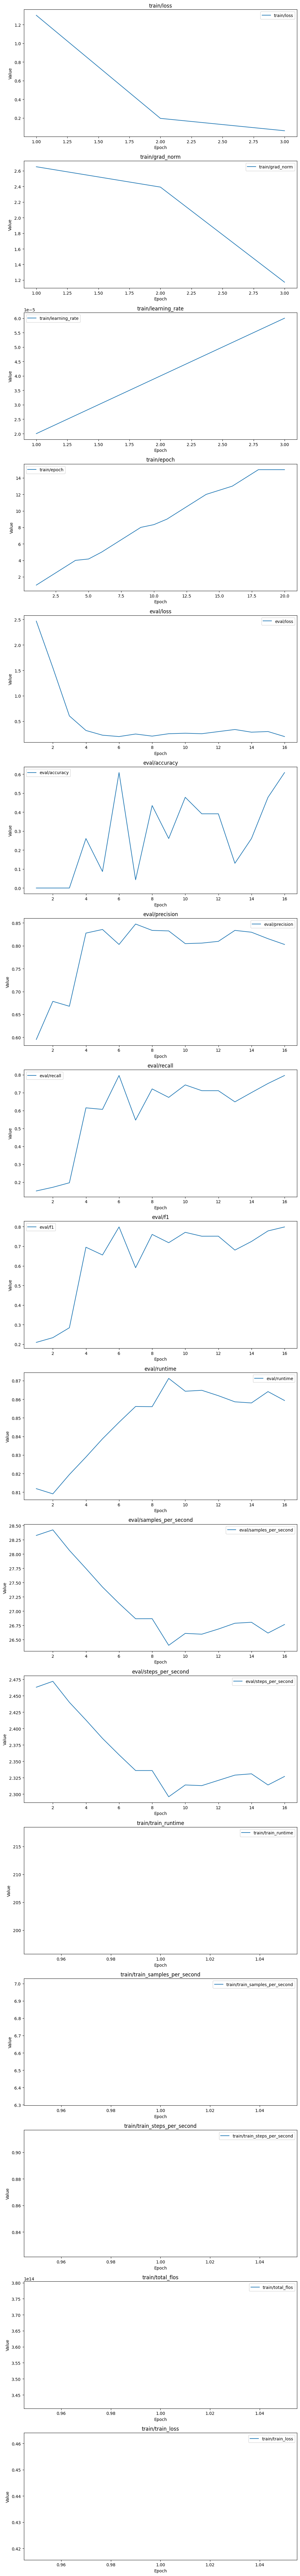

In [ ]:
policy_gpt_logdir = './policy_gpt_logs'

# Load the data
ea = event_accumulator.EventAccumulator(policy_gpt_logdir)
ea.Reload()

print(ea.Tags()['scalars'])

def extract_metric(metric_name):
    if metric_name in ea.scalars.Keys():
        return [x.value for x in ea.scalars.Items(metric_name)]
    else:
        return []

metrics_dict = {key: extract_metric(key) for key in ['train/loss',
                                                     'train/grad_norm',
                                                     'train/learning_rate',
                                                     'train/epoch',
                                                     'eval/loss',
                                                     'eval/accuracy',
                                                     'eval/precision',
                                                     'eval/recall', 'eval/f1',
                                                     'eval/runtime',
                                                     'eval/samples_per_second',
                                                     'eval/steps_per_second',
                                                     'train/train_runtime',
                                                     'train/train_samples_per_second',
                                                     'train/train_steps_per_second',
                                                     'train/total_flos', 'train/train_loss']
}

num_plots = len(metrics_dict)

fig, axs = plt.subplots(num_plots, 1, figsize=(10, 5 * num_plots))
axs = axs.flatten()

# plot each metric
for i, (metric, values) in enumerate(metrics_dict.items()):
    epochs = range(1, len(values)+1)
    axs[i].plot(epochs, values, label=metric)
    axs[i].set_title(metric)
    axs[i].set_xlabel('Epoch')
    axs[i].set_ylabel('Value')
    axs[i].legend()

plt.tight_layout()
plt.show()


## ACL-Coling Dataset

In [ ]:
nlp = spacy.load("en_core_web_sm")

def preprocess_text(text):
    return ' '.join(text.split()).lower()

preprocessed_policies = []
directory = './acl_corpus/corpus/'

for filename in os.listdir(directory):
    if filename.endswith('.xml'):
        path = os.path.join(directory, filename)
        tree = ET.parse(path)
        root = tree.getroot()

        full_policy_text = ""

        for section in root.findall('.//SECTION/SUBTEXT'):
            if section.text:
                full_policy_text += ' ' + section.text

        if full_policy_text:
            preprocessed_policy = preprocess_text(full_policy_text)
            preprocessed_policies.append(preprocessed_policy)
        else:
            print(f"No meaningful content found in {filename}, policy skipped.")

print(f"Number of processed privacy policies: {len(preprocessed_policies)}")


Number of processed privacy policies: 1010


### SBERT (saved model)

In [ ]:
def load_model(path, embedding_dim):
    model = SBertPolicyClassifier(embedding_dim, num_labels=7)
    model.load_state_dict(torch.load(path))
    model.eval()
    return model

embedding_dim = 384
policy_sbert_classifier_model = load_model('./policy_sbert_model_path.pth', embedding_dim)
policy_sbert_classifier_model.to(device)


SBertPolicyClassifier(
  (lstm): LSTM(384, 256, num_layers=2, batch_first=True, bidirectional=True)
  (attention): Linear(in_features=512, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=512, out_features=7, bias=True)
)

In [ ]:
def policy_sbert_classify_policy(policies, classifier, threshold=0.5):
    results = []
    unique_labels = set()

    for policy in policies:
        embedding = policy_sbert_model.encode(policy, convert_to_tensor=True).to(device)

        with torch.no_grad():
            outputs = classifier(embedding.unsqueeze(0))
            probs = torch.sigmoid(outputs).squeeze(0)

        policy_labels = []
        probs = probs.cpu().numpy()
        for idx, score in enumerate(probs):
            if score >= threshold:
                label = sbert_label_descriptions.get(idx, "Unknown Label")
                policy_labels.append((label, score))
                unique_labels.add(label)

        results.append((policy, policy_labels))
    return results, unique_labels


In [ ]:
policy_results, unique_labels = policy_sbert_classify_policy([preprocessed_policies[100]], policy_sbert_classifier_model, threshold=0.5)

print("Policy Classification Results:")
for policy, labels in policy_results:
    print(f"Policy: {policy}")
    for label, score in labels:
        print(f"  Prediction: {label}, Score: {score:.4f}")
    print()

print("\nUnique GDPR Labels identified in this policy:")
for label in unique_labels:
    print(label)


Policy Classification Results:
Policy: yanair website privacy statement ryanair is committed to protecting your privacy, our website privacy statement sets out what information we collect, how we collect it, what we do with it and how we protect this information. in order to process your booking, we collect personal details from you. these details may include (where applicable) passenger names, addresses, passport or government issued eu national id card numbers, telephone numbers, e-mail and ip addresses, credit/debit card or other payment details. in some instances we may also collect information regarding medical conditions (only for passengers who have special medical requirements) which may affect the chosen flight arrangements. your data may be used for the following purposes: contacting you in the event of a flight time change or cancellation, credit or other payment card verification/screening, immigration/customs control safety, security, health, administrative, crime preventi

### BERT (saved model)

In [ ]:
# load the model and tokenizer
policy_bert_model = BertForSequenceClassification.from_pretrained(policy_bert_model_path)
policy_bert_tokenizer = BertTokenizer.from_pretrained(policy_bert_model_path)

policy_bert_model.config.output_hidden_states = True


In [ ]:
policy_bert_classifier = pipeline("text-classification", model=policy_bert_model, tokenizer=policy_bert_tokenizer)

def policy_bert_classify_policy(policies, threshold=0.8):
    results = []
    unique_labels = set()
    for policy in policies:
        predictions = policy_bert_classifier(policy)
        policy_labels = []
        for pred in predictions:
            if pred['score'] >= threshold:
                label = label_descriptions.get(pred['label'], "Unknown Label")
                policy_labels.append((label, pred['score']))
                unique_labels.add(label)
        results.append((policy, policy_labels))
    return results, unique_labels

# processing and classifying one policy
if preprocessed_policies:
    policy_results, unique_labels = policy_bert_classify_policy([preprocessed_policies[100][:500]], threshold=0.8)

    print("Policy Classification Results:")
    for policy, labels in policy_results:
        print(f"Policy: {policy}")
        for label, score in labels:
            print(f"  Prediction: {label}, Score: {score:.4f}")
        print()

    print("\nUnique GDPR Labels identified in this policy:")
    for label in unique_labels:
        print(label)


Policy Classification Results:
Policy: yanair website privacy statement ryanair is committed to protecting your privacy, our website privacy statement sets out what information we collect, how we collect it, what we do with it and how we protect this information. in order to process your booking, we collect personal details from you. these details may include (where applicable) passenger names, addresses, passport or government issued eu national id card numbers, telephone numbers, e-mail and ip addresses, credit/debit card or other 
  Prediction: Purpose Limitation, Score: 0.9389


Unique GDPR Labels identified in this policy:
Purpose Limitation


### GPT2 (saved model)

In [ ]:
# load the model and tokenizer
policy_gpt_model = GPT2ForSequenceClassification.from_pretrained(policy_gpt_model_path)
policy_gpt_tokenizer = GPT2Tokenizer.from_pretrained(policy_gpt_model_path)

policy_gpt_model.config.output_hidden_states = True


In [ ]:
policy_gpt_classifier = pipeline("text-classification", model=policy_gpt_model, tokenizer=policy_gpt_tokenizer)

def policy_gpt_classify_policy(policies, threshold=0.8):
    results = []
    unique_labels = set()
    for policy in policies:
        predictions = policy_gpt_classifier(policy)
        policy_labels = []
        for pred in predictions:
            if pred['score'] >= threshold:
                label = label_descriptions.get(pred['label'], "Unknown Label")
                policy_labels.append((label, pred['score']))
                unique_labels.add(label)
        results.append((policy, policy_labels))
    return results, unique_labels

# processing and classifying one policy
if preprocessed_policies:
    policy_results, unique_labels = policy_gpt_classify_policy([preprocessed_policies[610][:500]], threshold=0.8)

    print("Policy Classification Results:")
    for policy, labels in policy_results:
        print(f"Policy: {policy}")
        for label, score in labels:
            print(f"  Prediction: {label}, Score: {score:.4f}")
        print()

    print("\nUnique GDPR Labels identified in this policy:")
    for label in unique_labels:
        print(label)


Policy Classification Results:
Policy: yanair website privacy statement ryanair is committed to protecting your privacy, our website privacy statement sets out what information we collect, how we collect it, what we do with it and how we protect this information. in order to process your booking, we collect personal details from you. these details may include (where applicable) passenger names, addresses, passport or government issued eu national id card numbers, telephone numbers, e-mail and ip addresses, credit/debit card or other 
  Prediction: Data Minimization, Score: 0.9906


Unique GDPR Labels identified in this policy:
Data Minimization


# API models

## Sentence Level

### GPT ADA model

In [ ]:
client = OpenAI()

completion = client.chat.completions.create(
  model="gpt-4o",
  messages=[
    {"role": "user", "content": "Do you know about GDPR compliance? Specifically the principles from article 5 of the GDPR?"},
    {"role": "user", "content": "Hello!"}
  ]
)

display_open_ai_response(completion.choices[0].message.content)


Hello! Yes, I'm familiar with GDPR compliance and the principles outlined in Article 5 of the General Data         
Protection Regulation (GDPR). Article 5 of the GDPR sets forth the principles relating to the processing of        
personal data. Here are the key principles:                                                                        

 1 Lawfulness, fairness, and transparency: Personal data must be processed lawfully, fairly, and in a transparent  
   manner in relation to the data subject.                                                                         
 2 Purpose limitation: Personal data must be collected for specified, explicit, and legitimate purposes and not    
   further processed in a manner that is incompatible with those purposes.                                         
 3 Data minimization: Personal data must be adequate, relevant, and limited to what is necessary in relation to the
   purposes for which they are processed.                                                                          
 4 Accuracy: Personal data must be accurate and, where necessary, kept up to date. Every reasonable step must be   
   taken to ensure that inaccurate personal data are erased or rectified without delay.                            
 5 Storage limitation: Personal data must be kept in a form that permits identification of data subjects for no    
   longer than is necessary for the purposes for which the personal data are processed.                            
 6 Integrity and confidentiality: Personal data must be processed in a manner that ensures appropriate security of 
   the personal data, including protection against unauthorized or unlawful processing and against accidental loss,
   destruction, or damage, using appropriate technical or organizational measures.                                 
 7 Accountability: The data controller is responsible for, and must be able to demonstrate compliance with, all the
   above principles.                                                                                               

These principles form the foundation of GDPR compliance and are designed to protect the rights and freedoms of     
individuals with respect to their personal data. If you have any more specific questions or need further details,  
feel free to ask!

In [ ]:
client = OpenAI(
    api_key=os.environ.get("OPENAI_API_KEY"),
)

def get_ada_embeddings(texts):
    ada_embeddings = []
    for text in tqdm(texts):
        response = client.embeddings.create(
            model="text-embedding-3-large",
            input=text,
            encoding_format="float"
        )
        ada_embeddings.append(response.data[0].embedding)
    return ada_embeddings


In [ ]:
class AdaPrivacyPolicyDataset(Dataset):
    def __init__(self, texts, labels):
        """
        Args:
            texts (list of str): List of sentence texts.
            labels (list of int): Corresponding labels for each text.
        """
        self.texts = texts
        self.labels = labels
        self.embeddings = get_ada_embeddings(self.texts)

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        embedding = torch.tensor(self.embeddings[idx], dtype=torch.float)
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return embedding, label

ada_preprocessed_policies = sentences_df['sentence_text'].tolist()
ada_labels = sentences_df['sentence_labels'].tolist()

train_texts, val_texts, train_labels, val_labels = train_test_split(ada_preprocessed_policies, ada_labels, test_size=0.2)

train_dataset = AdaPrivacyPolicyDataset(train_texts, train_labels)
val_dataset = AdaPrivacyPolicyDataset(val_texts, val_labels)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)


In [ ]:
def ada_compute_metrics(preds, labels):
    """
    Compute metrics like accuracy, precision, recall, and F1 score.
    Args:
        preds: Predictions from the model.
        labels: Actual labels.
    Returns:
        A dictionary with accuracy, precision, recall, and F1 score.
    """
    accuracy = accuracy_score(labels, preds)
    precision = precision_score(labels, preds, average='macro', zero_division=0)
    recall = recall_score(labels, preds, average='macro', zero_division=0)
    f1 = f1_score(labels, preds, average='macro', zero_division=0)
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }


In [ ]:
class TextClassifier(nn.Module):
    def __init__(self, embedding_dim, num_labels):
        super(TextClassifier, self).__init__()
        self.fc1 = nn.Linear(embedding_dim, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, num_labels)
        self.output = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.output(x)
        return x


In [ ]:
def train_and_validate(model, train_loader, val_loader, criterion, optimizer, num_epochs, device):
    history = {
        'train_loss': [],
        'val_loss': [],
        'train_accuracy': [],
        'val_accuracy': [],
        'train_precision': [],
        'val_precision': [],
        'train_recall': [],
        'val_recall': [],
        'train_f1': [],
        'val_f1': []
    }

    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0
        true_labels = []
        pred_labels = []

        for embeddings, labels in train_loader:
            embeddings, labels = embeddings.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(embeddings)
            loss = criterion(outputs.squeeze(), labels.float())
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()
            predicted = outputs.squeeze().detach().cpu().numpy() > 0.8
            true_labels.extend(labels.cpu().numpy())
            pred_labels.extend(predicted)

        train_metrics = ada_compute_metrics(pred_labels, true_labels)
        avg_train_loss = total_train_loss / len(train_loader)

        model.eval()
        total_val_loss = 0
        val_true_labels = []
        val_pred_labels = []

        with torch.no_grad():
            for embeddings, labels in val_loader:
                embeddings, labels = embeddings.to(device), labels.to(device)
                outputs = model(embeddings)
                loss = criterion(outputs.squeeze(), labels.float())
                total_val_loss += loss.item()

                predicted = outputs.squeeze().detach().cpu().numpy() > 0.8
                val_true_labels.extend(labels.cpu().numpy())
                val_pred_labels.extend(predicted)

        val_metrics = ada_compute_metrics(val_pred_labels, val_true_labels)
        avg_val_loss = total_val_loss / len(val_loader)

        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(avg_val_loss)
        for key in train_metrics:
            history['train_' + key].append(train_metrics[key])
            history['val_' + key].append(val_metrics[key])

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')
        print(f'Train Metrics: {train_metrics}')
        print(f'Val Metrics: {val_metrics}')

    return model, history


In [ ]:
embedding_dim = 3072
num_labels = 7
ada_sentence_classifier_model = TextClassifier(embedding_dim, num_labels).to(device)

criterion = nn.BCELoss()
optimizer = Adam(ada_sentence_classifier_model.parameters(), lr=0.001)

ada_sentence_model, ada_sentence_history = train_and_validate(
    ada_sentence_classifier_model, train_loader, val_loader, criterion, optimizer, num_epochs=10, device=device
)


Epoch 1/10, Train Loss: 0.2859, Val Loss: 0.2587
Train Metrics: {'accuracy': 0.4212562353659778, 'precision': 0.5385023691972628, 'recall': 0.22254247622551523, 'f1': 0.29305027078473644}
Val Metrics: {'accuracy': 0.4796416938110749, 'precision': 0.5348433362149073, 'recall': 0.2664654566704681, 'f1': 0.3477151157490585}
Epoch 2/10, Train Loss: 0.2337, Val Loss: 0.2485
Train Metrics: {'accuracy': 0.5465743662832129, 'precision': 0.6789188530250764, 'recall': 0.32500027961223293, 'f1': 0.403619610265944}
Val Metrics: {'accuracy': 0.5513029315960912, 'precision': 0.6636407802746863, 'recall': 0.33975280752371545, 'f1': 0.4188076470975145}
Epoch 3/10, Train Loss: 0.2224, Val Loss: 0.2450
Train Metrics: {'accuracy': 0.5681563677084394, 'precision': 0.814287553363504, 'recall': 0.35007891395582075, 'f1': 0.43554039775088665}
Val Metrics: {'accuracy': 0.5496742671009772, 'precision': 0.8043982412910082, 'recall': 0.3466900711319846, 'f1': 0.44090308029665515}
Epoch 4/10, Train Loss: 0.2138, 

In [ ]:
torch.save(ada_sentence_model, './ada_sentence_model.pth')


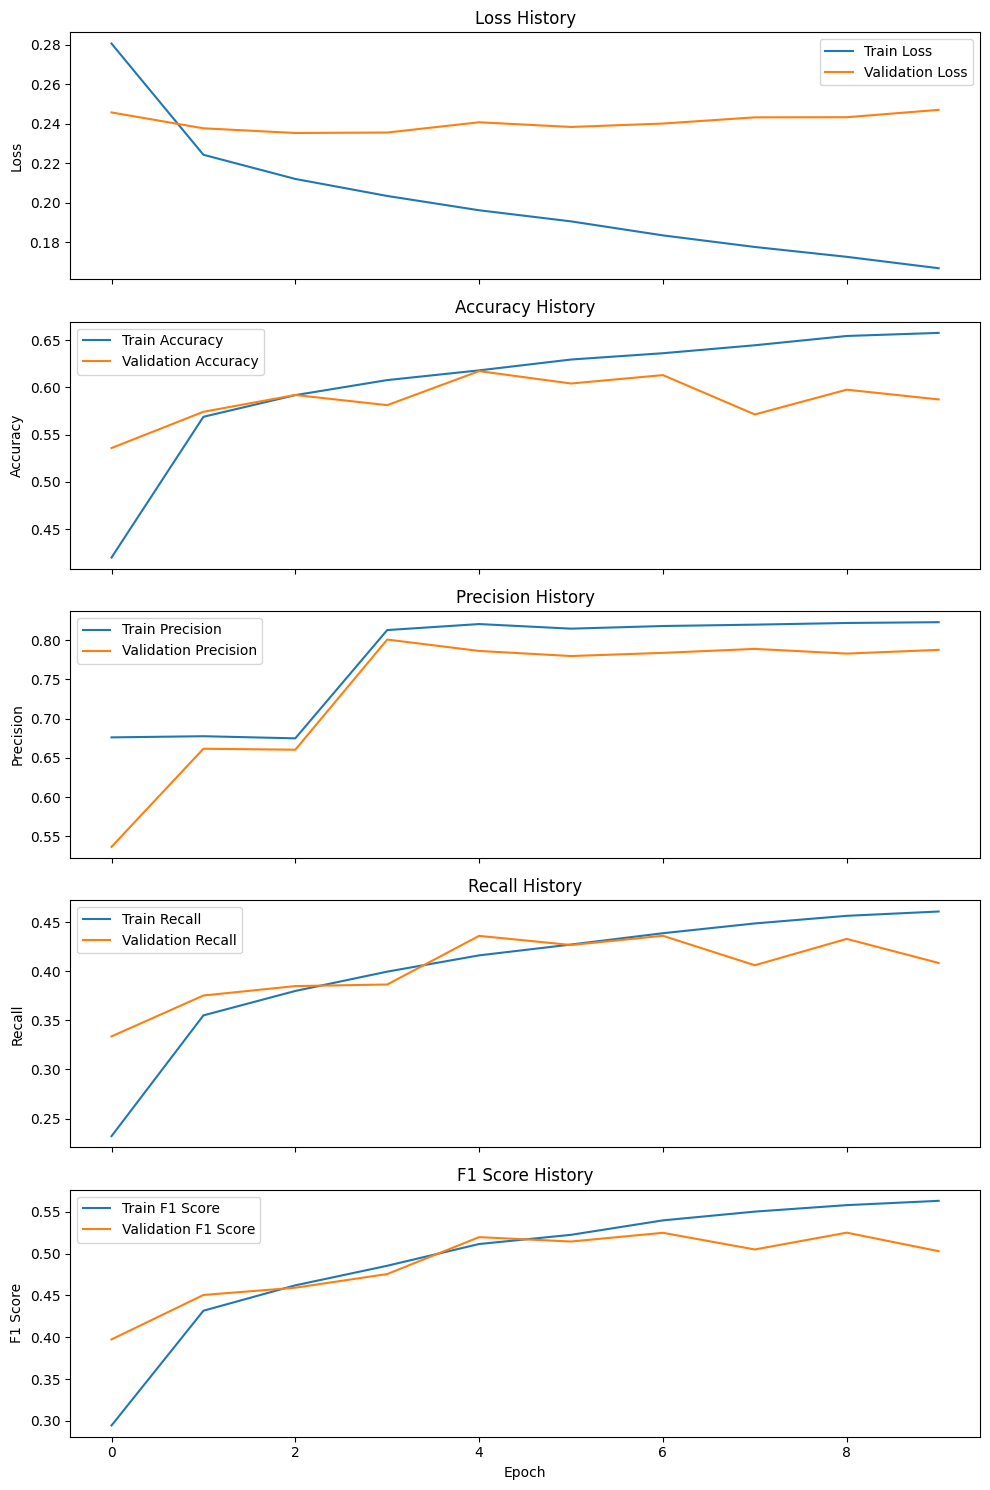

In [ ]:
def plot_history(history):
    num_plots = 5
    fig, axs = plt.subplots(num_plots, 1, figsize=(10, num_plots * 3), sharex=True)

    axs[0].plot(history['train_loss'], label='Train Loss')
    axs[0].plot(history['val_loss'], label='Validation Loss')
    axs[0].set_title('Loss History')
    axs[0].set_ylabel('Loss')
    axs[0].legend()

    axs[1].plot(history['train_accuracy'], label='Train Accuracy')
    axs[1].plot(history['val_accuracy'], label='Validation Accuracy')
    axs[1].set_title('Accuracy History')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend()

    axs[2].plot(history['train_precision'], label='Train Precision')
    axs[2].plot(history['val_precision'], label='Validation Precision')
    axs[2].set_title('Precision History')
    axs[2].set_ylabel('Precision')
    axs[2].legend()

    axs[3].plot(history['train_recall'], label='Train Recall')
    axs[3].plot(history['val_recall'], label='Validation Recall')
    axs[3].set_title('Recall History')
    axs[3].set_ylabel('Recall')
    axs[3].legend()

    axs[4].plot(history['train_f1'], label='Train F1 Score')
    axs[4].plot(history['val_f1'], label='Validation F1 Score')
    axs[4].set_title('F1 Score History')
    axs[4].set_ylabel('F1 Score')
    axs[4].legend()

    axs[-1].set_xlabel('Epoch')

    plt.tight_layout()
    plt.show()

plot_history(ada_sentence_history)


In [ ]:
ada_sentence_model = torch.load('./ada_sentence_model.pth')
ada_sentence_model.to(device)
ada_sentence_model.eval()

def predict_policy(policy_text, model, tokenizer):
    doc = nlp(policy_text)
    sentences = [sentence.text.strip() for sentence in doc.sents]

    embeddings = get_ada_embeddings(sentences)

    unique_principles = set()
    for embedding in embeddings:
        embedding_tensor = torch.tensor(embedding, dtype=torch.float).unsqueeze(0).to(device)
        with torch.no_grad():
            output = model(embedding_tensor)
            predicted = (torch.sigmoid(output).cpu().numpy() > 0.73).astype(int)

        principles = [index for index, is_compliant in enumerate(predicted[0]) if is_compliant]
        unique_principles.update(principles)

    principle_names = [sbert_label_descriptions[index] for index in unique_principles]
    return principle_names

predicted_principles = predict_policy(preprocessed_policies[100], ada_sentence_classifier_model, nlp)
print("Unique GDPR Principles identified:", predicted_principles)


100%|██████████| 93/93 [00:24<00:00,  3.73it/s]

Unique GDPR Principles identified: ['Lawfulness, Fairness and Transparency', 'Purpose Limitation', 'Data Minimization']


In [ ]:
def predict_policy(policy_text, model, tokenizer, threshold):
    doc = nlp(policy_text)
    sentences = [sentence.text.strip() for sentence in doc.sents]

    embeddings = get_ada_embeddings(sentences)

    unique_principles = set()
    for embedding in embeddings:
        embedding_tensor = torch.tensor(embedding, dtype=torch.float).unsqueeze(0).to(device)
        with torch.no_grad():
            output = model(embedding_tensor)
            predicted = (torch.sigmoid(output).cpu().numpy() > threshold).astype(int)

        principles = [index for index, is_compliant in enumerate(predicted[0]) if is_compliant]
        unique_principles.update(principles)

    principle_names = [sbert_label_descriptions[index] for index in unique_principles]
    return principle_names

thresholds = [0.5, 0.6, 0.7, 0.8, 0.9]
results = {}
for threshold in thresholds:
    predicted_principles = predict_policy(preprocessed_policies[100], ada_sentence_classifier_model, nlp, threshold)
    results[threshold] = predicted_principles

for threshold, principles in results.items():
    print(f"Threshold {threshold}: {principles}")


100%|██████████| 93/93 [00:28<00:00,  3.26it/s]

Threshold 0.5: ['Lawfulness, Fairness and Transparency', 'Purpose Limitation', 'Data Minimization', 'Accuracy', 'Storage Limitation', 'Integrity and Confidentiality', 'Accountability']
Threshold 0.6: ['Lawfulness, Fairness and Transparency', 'Purpose Limitation', 'Data Minimization', 'Accuracy', 'Integrity and Confidentiality']
Threshold 0.7: ['Lawfulness, Fairness and Transparency', 'Purpose Limitation', 'Data Minimization', 'Accuracy', 'Integrity and Confidentiality']
Threshold 0.8: []
Threshold 0.9: []


In [ ]:
!pip freeze > requirements.txt


In [ ]:
print("done")

done
